 
  <h1><center> Analyze life expectancy</center></h1>

The life expectancy data is from kaggle, https://www.kaggle.com/kumarajarshi/life-expectancy-who. It contains 193 countries data. There are 22 columns in the dataset. All predicting variables was then divided into several broad categories:Immunization related factors, Mortality factors, Economical factors and Social factors.Through the analysis, we want to answer the following questions:
- The life expectancy between developed countries and developing countries are siginificant different?
- Which factors affect the life expectancy?
- Will Immunization factor play a role in the average age of life expectancy?
- How adult mortality and infant mortality affect life expectancy?
- How economic factors affect life expectancy?
- Do social factors have same effect on life expectancy?
- How about the countries with very short life expectancy? Are the factors the same with developing countries?


In [1]:
from google.cloud import storage
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

In [2]:
lifeExpec = pd.read_csv('gs://life2/LifeExpectancyData.csv', sep=",")

In [3]:
lifeExpec.head()

Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0            263.0   
1  Afghanistan  2014  Developing              59.9            271.0   
2  Afghanistan  2013  Developing              59.9            268.0   
3  Afghanistan  2012  Developing              59.5            272.0   
4  Afghanistan  2011  Developing              59.2            275.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   ...  \
0             62     0.01               71.279624         65.0      1154  ...   
1             64     0.01               73.523582         62.0       492  ...   
2             66     0.01               73.219243         64.0       430  ...   
3             69     0.01               78.184215         67.0      2787  ...   
4             71     0.01                7.097109         68.0      3013  ...   

   Polio  Total expenditure  Diphtheria    HIV/AIDS         GDP  Population  \
0    6.0               8.16         65.0        0.1  574.184114  33736494.0   
1   58.0               8.18         62.0        0.1  583.656193  32758020.0   
2   62.0               8.13         64.0        0.1  587.565090  31731688.0   
3   67.0               8.52         67.0        0.1  576.190126  30696958.0   
4   68.0               7.87         68.0        0.1  528.736648  29708599.0   

    thinness  1-19 years   thinness 5-9 years  \
0                   17.2                 17.3   
1                   17.5                 17.5   
2                   17.7                 17.7   
3                   17.9                 18.0   
4                   18.2                 18.2   

   Income composition of resources  Schooling  
0                            0.479       10.1  
1                            0.476       10.0  
2                            0.470        9.9  
3                            0.463        9.8  
4                            0.454        9.5  

[5 rows x 22 columns]

In [4]:
lifeExpec.shape

(2938, 22)

In [5]:
lifeExpec.rename(columns={" BMI ":"BMI","Life expectancy ":"Life_Expectancy","Adult Mortality":"Adult_Mortality",
                   "infant deaths":"Infant_Deaths","percentage expenditure":"Percentage_Exp","Hepatitis B":"HepatitisB",
                  "Measles ":"Measles"," BMI ":"BMI","under-five deaths ":"Under_Five_Deaths","Diphtheria ":"Diphtheria",
                  " HIV/AIDS":"HIV/AIDS"," thinness  1-19 years":"thinness_10to19_years"," thinness 5-9 years":"thinness_5to9_years","Income composition of resources":"Income_Comp_Of_Resources",
                   "Total expenditure":"Tot_Exp"},inplace=True)

In [6]:
lifeExpec.columns

Index(['Country', 'Year', 'Status', 'Life_Expectancy', 'Adult_Mortality',
       'Infant_Deaths', 'Alcohol', 'Percentage_Exp', 'HepatitisB', 'Measles',
       'BMI', 'Under_Five_Deaths', 'Polio', 'Tot_Exp', 'Diphtheria',
       'HIV/AIDS', 'GDP', 'Population', 'thinness_10to19_years',
       'thinness_5to9_years', 'Income_Comp_Of_Resources', 'Schooling'],
      dtype='object')

In [7]:
lifeExpec.isnull().sum()

Country                       0
Year                          0
Status                        0
Life_Expectancy              10
Adult_Mortality              10
Infant_Deaths                 0
Alcohol                     194
Percentage_Exp                0
HepatitisB                  553
Measles                       0
BMI                          34
Under_Five_Deaths             0
Polio                        19
Tot_Exp                     226
Diphtheria                   19
HIV/AIDS                      0
GDP                          96
Population                    6
thinness_10to19_years        34
thinness_5to9_years          34
Income_Comp_Of_Resources    167
Schooling                   163
dtype: int64

In [8]:
country_list = lifeExpec.Country.unique()
fill_list = ['Life_Expectancy','Adult_Mortality','Alcohol','HepatitisB','BMI','Polio','Tot_Exp','Diphtheria','GDP','Population','thinness_10to19_years','thinness_5to9_years','Income_Comp_Of_Resources','Schooling']

In [9]:
for country in country_list:
    lifeExpec.loc[lifeExpec['Country'] == country,fill_list] = lifeExpec.loc[lifeExpec['Country'] == country,fill_list].interpolate()

In [10]:
# Drop remaining null values after interpolation.
lifeExpec.dropna(inplace=True)
lifeExpec.shape

(2410, 22)

In [11]:
countryNames = lifeExpec.Country.unique()
countryNames.size

161

In [12]:
life = lifeExpec.drop('Year', axis = 1)

In [13]:
decribe = life.describe()

In [14]:
decribe.round(2)

Life_Expectancy  Adult_Mortality  Infant_Deaths  Alcohol  \
count          2410.00          2410.00        2410.00  2410.00   
mean             68.91           165.54          31.46     4.34   
std               9.20           123.93         126.64     3.95   
min              36.30             1.00           0.00     0.01   
25%              63.30            76.00           0.00     0.70   
50%              71.80           146.00           3.00     3.46   
75%              75.00           225.75          21.00     7.22   
max              89.00           723.00        1800.00    17.87   

       Percentage_Exp  HepatitisB    Measles      BMI  Under_Five_Deaths  \
count         2410.00     2410.00    2410.00  2410.00            2410.00   
mean           673.95       75.98    2341.07    37.73              43.58   
std           1694.80       28.44   11050.63    19.85             172.43   
min              0.00        2.00       0.00     1.00               0.00   
25%             17.02       66.00       0.00    18.70               0.00   
50%             91.49       89.00      15.00    42.90               4.00   
75%            472.92       96.00     356.25    55.60              26.00   
max          18961.35       99.00  212183.00    77.10            2500.00   

         Polio  Tot_Exp  Diphtheria  HIV/AIDS        GDP    Population  \
count  2410.00  2410.00     2410.00   2410.00    2410.00  2.410000e+03   
mean     82.09     5.77       82.15      1.72   10202.08  3.636359e+07   
std      23.56     2.31       23.59      4.71   15385.91  1.411312e+08   
min       3.00     0.37        2.00      0.10     194.87  8.113100e+04   
25%      77.00     4.24       78.00      0.10    1282.14  2.059850e+06   
50%      93.00     5.63       92.00      0.10    3890.07  7.489080e+06   
75%      97.00     7.20       97.00      0.80   10479.23  2.317568e+07   
max      99.00    14.39       99.00     43.50  111968.35  1.364270e+09   

       thinness_10to19_years  thinness_5to9_years  Income_Comp_Of_Resources  \
count                2410.00              2410.00                   2410.00   
mean                    5.06                 5.11                      0.62   
std                     4.57                 4.66                      0.21   
min                     0.10                 0.10                      0.00   
25%                     1.70                 1.70                      0.49   
50%                     3.50                 3.40                      0.67   
75%                     7.40                 7.40                      0.76   
max                    27.70                28.60                      0.94   

       Schooling  
count    2410.00  
mean       11.85  
std         3.16  
min         0.00  
25%        10.00  
50%        12.20  
75%        13.90  
max        20.70

In [15]:
round(lifeExpec[['Status','Life_Expectancy']].groupby(['Status']).mean(),2)

Life_Expectancy
Status                     
Developed             78.87
Developing            67.33

In [16]:
lifeExpec[lifeExpec['Status'] == "Developing"].shape[0]/lifeExpec.shape[0]

0.8630705394190872

In [17]:
lifeExpec[lifeExpec['Status'] == "Developed"].shape[0]/lifeExpec.shape[0]

0.13692946058091288

The percentage of developing countries among all countries is 86.31%, while developed countries only account of 13.69% of total data. This is an unbalanced dataset, the analysis result will be dominated by the majority class, developing countries. So, we will analayze developing countries and developed countries separately. 

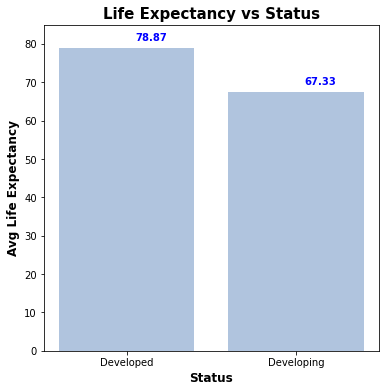

In [18]:
## life Expectancy vs status 
l =(round(lifeExpec.groupby('Status')['Life_Expectancy'].mean(), 2).to_numpy())
plt.figure(figsize=(6,6))
plt.bar(lifeExpec.groupby('Status')['Status'].count().index,lifeExpec.groupby('Status')['Life_Expectancy'].mean(), color = "lightsteelblue")
plt.xlabel("Status",fontsize=12,fontweight='bold')
plt.ylabel("Avg Life Expectancy",fontsize=12,fontweight='bold')
plt.ylim(0, 85)
plt.title("Life Expectancy vs Status", fontsize=15,fontweight='bold')
for i, v in enumerate(l):
    plt.text(i +0.05,v +2,str(v), color='blue', fontweight='bold' )
plt.show()

In [19]:
stats.ttest_ind(lifeExpec.loc[lifeExpec['Status']=='Developed','Life_Expectancy'],lifeExpec.loc[lifeExpec['Status']=='Developing','Life_Expectancy'])

Ttest_indResult(statistic=23.449888363481808, pvalue=1.0626781954055896e-109)

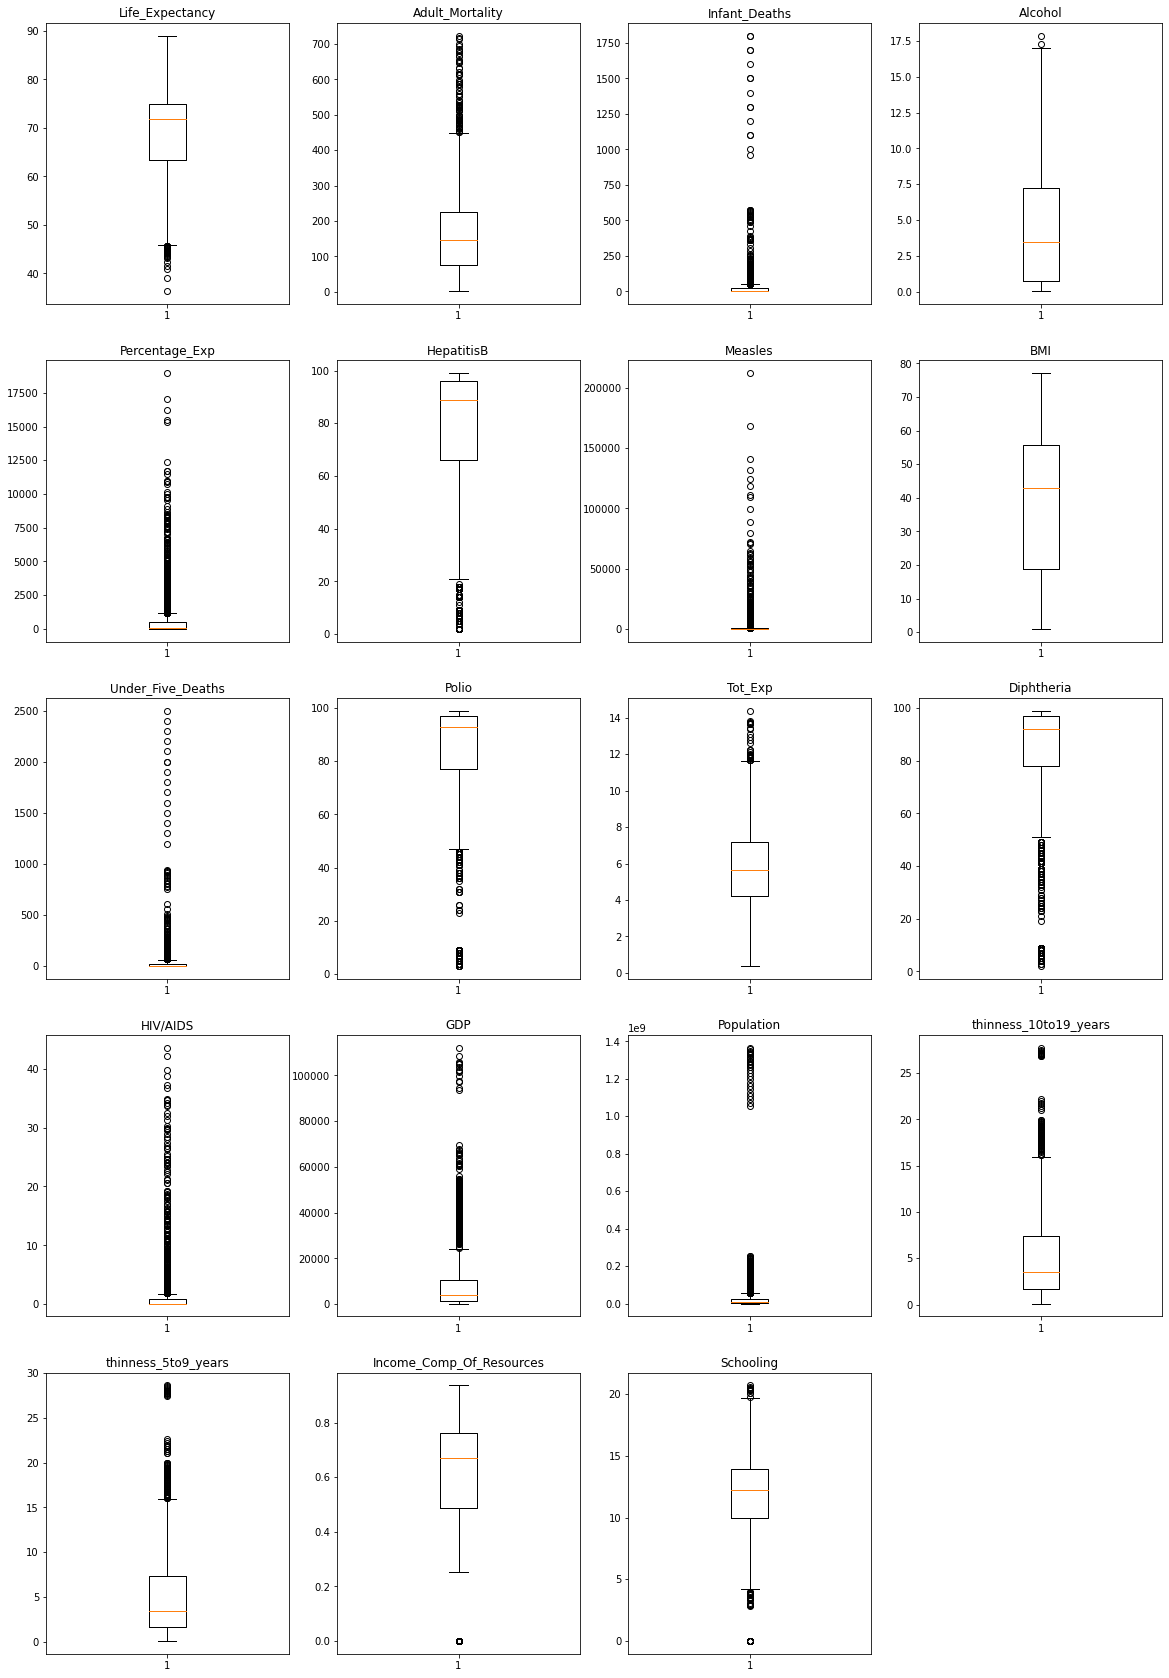

In [20]:
## check outliers using boxplot
col_dict = {'Life_Expectancy':1,'Adult_Mortality':2,'Infant_Deaths':3,'Alcohol':4,'Percentage_Exp':5,'HepatitisB':6,'Measles':7,'BMI':8,'Under_Five_Deaths':9,'Polio':10,'Tot_Exp':11,'Diphtheria':12,'HIV/AIDS':13,'GDP':14,'Population':15,'thinness_10to19_years':16,
            'thinness_5to9_years':17,'Income_Comp_Of_Resources':18,'Schooling':19}
plt.figure(figsize=(20,30))

for variable,i in col_dict.items():
                     plt.subplot(5,4,i)
                     plt.boxplot(lifeExpec[variable],whis=1.5)
                     plt.title(variable)

plt.show()

The boxplot results shows there are outliers exist in each variables. Next, we will take a look at each indivual variable, 
to see if we need to normalize the variables.

In [21]:
## check life Expecancy
lifeExpec[lifeExpec["Life_Expectancy"] < 45]

Country  Year      Status  Life_Expectancy  Adult_Mortality  \
1127         Haiti  2010  Developing             36.3            682.0   
1484       Lesotho  2005  Developing             44.5            675.0   
1485       Lesotho  2004  Developing             44.8            666.0   
1582        Malawi  2003  Developing             44.6            613.0   
1583        Malawi  2002  Developing             44.0             67.0   
1584        Malawi  2001  Developing             43.5            599.0   
1585        Malawi  2000  Developing             43.1            588.0   
2306  Sierra Leone  2006  Developing             44.3            464.0   
2307  Sierra Leone  2005  Developing             43.3             48.0   
2308  Sierra Leone  2004  Developing             42.3            496.0   
2309  Sierra Leone  2003  Developing             41.5             57.0   
2311  Sierra Leone  2001  Developing             41.0            519.0   
2312  Sierra Leone  2000  Developing             39.0            533.0   
2920        Zambia  2001  Developing             44.6            611.0   
2921        Zambia  2000  Developing             43.8            614.0   
2932      Zimbabwe  2005  Developing             44.6            717.0   
2933      Zimbabwe  2004  Developing             44.3            723.0   
2934      Zimbabwe  2003  Developing             44.5            715.0   
2935      Zimbabwe  2002  Developing             44.8             73.0   

      Infant_Deaths  Alcohol  Percentage_Exp  HepatitisB  Measles  ...  Polio  \
1127             23     5.76       36.292918        68.0        0  ...   66.0   
1484              5     2.67       57.903698        87.0        0  ...   88.0   
1485              5     1.80       67.913618         6.0       31  ...   89.0   
1582             43     1.08        4.375316        84.0      167  ...   85.0   
1583             46     1.10        3.885395        64.0       92  ...   79.0   
1584             48     1.15       12.797606        64.0      150  ...   86.0   
1585             51     1.18       13.762702        64.0      304  ...   73.0   
2306             30     3.80       38.000758        63.0       33  ...   65.0   
2307             30     3.83       42.088929        63.0       29  ...   67.0   
2308             30     3.99       38.524548        63.0        7  ...   69.0   
2309             30     4.07       38.614732        63.0      586  ...   66.0   
2311             30     4.21       33.346915        63.0      649  ...   38.0   
2312             29     3.97       20.395683        63.0     3575  ...   46.0   
2920             43     2.61       46.830275        82.0    16997  ...   86.0   
2921             44     2.62       45.616880        82.0    30930  ...   85.0   
2932             28     4.14        8.717409        65.0      420  ...   69.0   
2933             27     4.36        0.000000        68.0       31  ...   67.0   
2934             26     4.06        0.000000         7.0      998  ...    7.0   
2935             25     4.43        0.000000        73.0      304  ...   73.0   

      Tot_Exp  Diphtheria  HIV/AIDS          GDP  Population  \
1127     8.90        66.0       1.9   665.627419   9999617.0   
1484     6.30        89.0      34.8   946.045953   1949543.0   
1485     6.96         9.0      34.6   909.874430   1933728.0   
1582     6.35        84.0      24.2   372.531249  12336687.0   
1583     4.82        64.0      24.7   361.043546  12013711.0   
1584     5.70         9.0      25.1   363.755174  11695863.0   
1585     6.70        75.0      25.5   392.524585  11376172.0   
2306     1.68        64.0       2.2   357.219530   5848692.0   
2307    12.25        65.0       2.2   353.889419   5658379.0   
2308    11.66        65.0       2.1   351.822124   5439695.0   
2309    11.69        73.0       1.9   344.826417   5199549.0   
2311    11.83        38.0       1.5   272.991178   4739147.0   
2312    13.63        44.0       1.2   302.264266   4564297.0   
2920     6.56

In [22]:
lifeExpec[lifeExpec["Country"] == 'Sierra Leone']['Life_Expectancy']

2298    48.1
2299    54.0
2300    49.7
2301    48.9
2302    48.1
2303    47.1
2304    46.2
2305    45.3
2306    44.3
2307    43.3
2308    42.3
2309    41.5
2310    48.0
2311    41.0
2312    39.0
Name: Life_Expectancy, dtype: float64

In [23]:
lifeExpec[lifeExpec["Country"] == 'Malawi']['Life_Expectancy']

1571    57.6
1572    56.7
1573    55.3
1574    54.1
1575    52.9
1576    51.5
1577    50.0
1578    48.5
1579    47.1
1580    46.0
1581    45.1
1582    44.6
1583    44.0
1584    43.5
1585    43.1
Name: Life_Expectancy, dtype: float64

In [24]:
lifeExpec[lifeExpec["Country"] == 'Lesotho']['Life_Expectancy']

1475    52.1
1476    52.1
1477    52.2
1478    52.3
1479    51.1
1480    49.4
1481    47.8
1482    46.2
1483    45.3
1484    44.5
1485    44.8
1486    45.5
1487    46.4
1488    47.8
1489    49.3
Name: Life_Expectancy, dtype: float64

In [25]:
lifeExpec[lifeExpec["Country"] == 'Zambia']['Life_Expectancy']

2907    61.1
2908    63.0
2909    59.2
2910    58.2
2911    58.0
2912    57.4
2913    55.7
2914    52.6
2915    58.0
2916    49.3
2917    47.9
2918    46.4
2919    45.5
2920    44.6
2921    43.8
Name: Life_Expectancy, dtype: float64

In [26]:
lifeExpec[lifeExpec["Country"] == 'Zimbabwe']['Life_Expectancy']

2923    59.2
2924    58.0
2925    56.6
2926    54.9
2927    52.4
2928    50.0
2929    48.2
2930    46.6
2931    45.4
2932    44.6
2933    44.3
2934    44.5
2935    44.8
2936    45.3
2937    46.0
Name: Life_Expectancy, dtype: float64

Based on the analysis above, the life Expectancy low is mainly because these data are from developing country. Here we will 
keep the data.


In [27]:
## check  Adult_Mortality
lifeExpec[lifeExpec["Adult_Mortality"] > 500]

Country  Year      Status  Life_Expectancy  \
346                   Botswana  2005  Developing             51.7   
347                   Botswana  2004  Developing             48.1   
348                   Botswana  2003  Developing             46.4   
349                   Botswana  2002  Developing             46.0   
350                   Botswana  2001  Developing             46.7   
351                   Botswana  2000  Developing             47.8   
522   Central African Republic  2005  Developing             45.9   
523   Central African Republic  2004  Developing             45.7   
865                    Eritrea  2000  Developing             45.3   
1127                     Haiti  2010  Developing             36.3   
1475                   Lesotho  2014  Developing             52.1   
1476                   Lesotho  2013  Developing             52.1   
1477                   Lesotho  2012  Developing             52.2   
1479                   Lesotho  2010  Developing             51.1   
1480                   Lesotho  2009  Developing             49.4   
1481                   Lesotho  2008  Developing             47.8   
1482                   Lesotho  2007  Developing             46.2   
1483                   Lesotho  2006  Developing             45.3   
1484                   Lesotho  2005  Developing             44.5   
1485                   Lesotho  2004  Developing             44.8   
1486                   Lesotho  2003  Developing             45.5   
1487                   Lesotho  2002  Developing             46.4   
1488                   Lesotho  2001  Developing             47.8   
1489                   Lesotho  2000  Developing             49.3   
1577                    Malawi  2008  Developing             50.0   
1578                    Malawi  2007  Developing             48.5   
1579                    Malawi  2006  Developing             47.1   
1581                    Malawi  2004  Developing             45.1   
1582                    Malawi  2003  Developing             44.6   
1584                    Malawi  2001  Developing             43.5   
1585                    Malawi  2000  Developing             43.1   
2310              Sierra Leone  2002  Developing             48.0   
2311              Sierra Leone  2001  Developing             41.0   
2312              Sierra Leone  2000  Developing             39.0   
2727                    Uganda  2002  Developing             48.8   
2728                    Uganda  2001  Developing             47.7   
2729                    Uganda  2000  Developing             46.6   
2915                    Zambia  2006  Developing             58.0   
2916                    Zambia  2005  Developing             49.3   
2917                    Zambia  2004  Developing             47.9   
2920                    Zambia  2001  Developing             44.6   
2921                    Zambia  2000  Developing             43.8   
2927                  Zimbabwe  2010  Developing             52.4   
2928                  Zimbabwe  2009  Developing             50.0   
2929                  Zimbabwe  2008  Developing             48.2   
2932                  Zimbabwe  2005  Developing             44.6   
2933                  Zimbabwe  2004  Developing             44.3   
2934                  Zimbabwe  2003  Developing             44.5   
2936                  Zimbabwe  2001  Developing             45.3   
2937                  Zimbabwe  2000  Developing             46.0   

      Adult_Mortality  Infant_Deaths  Alcohol  Percentage_Exp  HepatitisB  \
346             566.0              2     6.37      629.842564        92.0   
347             652.0              2     4.90      469.582390        91.0   
348             693.0              2     5.51      299.367125         9.0   
349             699.0              2     6.41        6.330007        88.0   
350             679.0              2     5.48      306.952735        87.0   
351             647.0              2     

The boxplot shows the data the mortality in some countries, such as Zimbabwe, Zambia, Lesotho, Botswana,Malawi are all high. 
That may be caused by some factors. We will do specific analysis on these countries to see if we can dig out some important 
information. Here, we mainly investigate Central African Republic, Eritrea,Haiti, Sierra Leone to see if the mortality is 
abnormal.

In [28]:
lifeExpec[lifeExpec["Country"] == 'Central African Republic']

Country  Year      Status  Life_Expectancy  \
513  Central African Republic  2014  Developing             58.0   
514  Central African Republic  2013  Developing             49.9   
515  Central African Republic  2012  Developing             53.0   
516  Central African Republic  2011  Developing             49.8   
517  Central African Republic  2010  Developing             49.2   
518  Central African Republic  2009  Developing             48.6   
519  Central African Republic  2008  Developing             47.6   
520  Central African Republic  2007  Developing             46.8   
521  Central African Republic  2006  Developing             46.3   
522  Central African Republic  2005  Developing             45.9   
523  Central African Republic  2004  Developing             45.7   
524  Central African Republic  2003  Developing             45.7   
525  Central African Republic  2002  Developing             45.6   
526  Central African Republic  2001  Developing             45.6   
527  Central African Republic  2000  Developing             46.0   

     Adult_Mortality  Infant_Deaths  Alcohol  Percentage_Exp  HepatitisB  \
513            437.0             15     0.01       53.439643        47.0   
514            451.0             16     0.01       52.377666        23.0   
515            439.0             16     0.01        7.344808        47.0   
516            443.0             16     1.66       58.529475        47.0   
517            446.0             17     1.67       43.483592        45.0   
518            453.0             17     1.56       40.451569        42.0   
519            477.0             17     1.52       67.341375        42.0   
520            495.0             17     1.50       60.048848        42.0   
521             56.0             17     1.54       46.901179        42.0   
522            511.0             17     1.50       40.922080        42.0   
523            512.0             17     1.50       41.501117        42.0   
524             51.0             17     1.49       46.116194        42.0   
525             58.0             17     1.47       31.594159        42.0   
526             54.0             17     1.52       33.653157        42.0   
527             49.0             16     1.51       30.783827        42.0   

     Measles  ...  Polio  Tot_Exp  Diphtheria  HIV/AIDS         GDP  \
513      210  ...   47.0     4.20        47.0       4.5  334.114551   
514      596  ...   23.0     3.82        23.0       5.1  335.062283   
515      141  ...   47.0     3.62        47.0       5.1  528.129707   
516      679  ...   47.0     3.73        47.0       5.8  504.746050   
517        2  ...   46.0     3.90        45.0       6.6  487.945383   
518       11  ...   45.0     3.58        42.0       7.3  471.633075   
519       12  ...   46.0     4.30        45.0       8.3  440.866694   
520       49  ...   46.0     4.40        48.0       9.0  439.747444   
521        3  ...   47.0     3.99        51.0      10.0  428.538856   
522      471  ...   47.0     4.29        54.0      11.2  417.095000   
523     1233  ...   45.0     4.10        51.0      12.0  421.535738   
524      652  ...   44.0     4.31        47.0      12.8  405.757985   
525      938  ...   42.0     4.16        44.0      13.4  437.826009   
526     2837  ...    4.0     3.95         4.0      13.9  431.639048   
527     3207  ...   38.0     4.24        37.0      14.3  422.451781   

     Population  thinness_10to19_years  thinness_5to9_years  \
513   4515392.0                    8.4                  8.3   
514   4499653.0                    8.5                  8.5   
515   4490416.0                    8.7                  8.6   
516   4476153.0                    8.8                  8.8   
517   4448525.0                    9.0                  8.9   
518   4404230.0                    9.1                  9.1   
519   4345386.0                    9.3                  9.2   
520   4275800.0                    9.4                  9.4   
521   420175

Adult Mortality in Central African Republic looks very abnormal, the Adult Mortality between 2000 and 2003 are very low, 
arount 50, however, after 2004, it increased dramatically. Based on data from world bank, 
https://data.worldbank.org/indicator/SP.DYN.AMRT.MA?locations=CF, the Adult Mortality is always above 390. So the Adult 
Mortality in 2000, 2001, 2002, 2003 and 2006 are not correct. Here, the Adult Mortality of those years will be modified 
based on world bank data. 

In [29]:
## make a copy
lifeExpecCopy = lifeExpec

In [30]:
## 2000 
lifeExpec.loc[527,'Adult_Mortality'] = 540.27   
## 2001
lifeExpec.loc[526,'Adult_Mortality'] = 548.42
## 2002
lifeExpec.loc[525,'Adult_Mortality'] = 556.57
##2003
lifeExpec.loc[524,'Adult_Mortality'] = 548.02
## 2006
lifeExpec.loc[521,'Adult_Mortality'] = 522.39

In [31]:
lifeExpec[lifeExpec["Country"] == 'Eritrea']

Country  Year      Status  Life_Expectancy  Adult_Mortality  \
854  Eritrea  2011  Developing             62.9            286.0   
855  Eritrea  2010  Developing             62.1            298.0   
856  Eritrea  2009  Developing             61.4            311.0   
857  Eritrea  2008  Developing             67.0            322.0   
858  Eritrea  2007  Developing             62.0            329.0   
859  Eritrea  2006  Developing             59.7            336.0   
860  Eritrea  2005  Developing             59.4             34.0   
861  Eritrea  2004  Developing             59.1            342.0   
862  Eritrea  2003  Developing             58.8            343.0   
863  Eritrea  2002  Developing             58.5            343.0   
864  Eritrea  2001  Developing             58.1            345.0   
865  Eritrea  2000  Developing             45.3            593.0   

     Infant_Deaths  Alcohol  Percentage_Exp  HepatitisB  Measles  ...  Polio  \
854              6     0.62       20.979919        96.0       48  ...   96.0   
855              6     0.61       17.357398         9.0       51  ...    9.0   
856              6     0.63        1.575160        92.0       82  ...   92.0   
857              6     0.49       11.765723        94.0        0  ...   94.0   
858              6     1.23       11.423860        91.0       55  ...   91.0   
859              7     0.97       10.602698        94.0      128  ...   94.0   
860              7     1.07        5.064689        96.0       19  ...   96.0   
861              7     0.64       10.260973        84.0       24  ...   98.0   
862              7     0.56        6.913998        91.0      376  ...   95.0   
863              7     0.83        0.703132        86.0      460  ...   92.0   
864              7     0.61        5.593620        86.0      204  ...   89.0   
865              7     0.83        0.735940        86.0      789  ...   82.0   

     Tot_Exp  Diphtheria  HIV/AIDS         GDP  Population  \
854     3.60        96.0       0.7  715.872542   4474690.0   
855     3.24         9.0       0.9  667.744178   4390840.0   
856     3.30        92.0       1.0  663.986573   4310334.0   
857     3.69        94.0       1.1  651.133111   4232636.0   
858     3.29        91.0       1.3  737.696469   4153332.0   
859     3.30        94.0       1.4  746.841751   4066648.0   
860     2.97        96.0       1.6  778.575536   3969007.0   
861     3.14        98.0       1.8  788.855630   3858623.0   
862     3.50        93.0       1.9  813.091934   3738265.0   
863     4.20         9.0       1.9  875.643306   3614639.0   
864     3.95        86.0       2.0  888.160096   3497124.0   
865     4.43        81.0       1.9  845.979095   3392801.0   

     thinness_10to19_years  thinness_5to9_years  Income_Comp_Of_Resources  \
854                    8.8                  8.7                     0.405   
855                    8.9                  8.8                     0.404   
856                    9.0                  8.9                     0.402   
857                    9.1                  9.1                     0.406   
858                    9.2                  9.2                     0.405   
859                    9.3                  9.3                     0.405   
860                    9.4                  9.5                     0.000   
861                    9.6                  9.6                     0.000   
862                    9.7                  9.7                     0.000   
863                    9.9                  9.9                     0.000   
864                    1.0                  1.0                     0.000   
865                    1.2                  1.1                     0.000   

     Schooling  
854        5.0  
855        5.1  
856        5.2  
857        5.2  
858        5.3  
859        5.3  
860        5.4  
861        5.0  
862        4.7  
863        4.4  
864        4.3  
865        3.9  

[12 rows x 22 columns]

The Adult_Mortality of Eritrea in 2005 is abnormal. Based on data from world bank, 
https://data.worldbank.org/indicator/SP.DYN.AMRT.MA, the Adult Mortality is 202.96. So we change the value of the Adult_Mortality of Eritrea in 2005 into 202.96.

In [32]:
##2005 Eritrea
lifeExpec.loc[860,'Adult_Mortality'] = 202.96

In [33]:
lifeExpec[lifeExpec["Country"] == 'Haiti']

Country  Year      Status  Life_Expectancy  Adult_Mortality  \
1123   Haiti  2014  Developing             63.1            245.0   
1124   Haiti  2013  Developing             62.7            253.0   
1125   Haiti  2012  Developing             62.3            259.0   
1126   Haiti  2011  Developing             62.3            259.0   
1127   Haiti  2010  Developing             36.3            682.0   
1128   Haiti  2009  Developing             62.5            251.0   
1129   Haiti  2008  Developing             62.1            259.0   
1130   Haiti  2007  Developing             61.8            266.0   
1131   Haiti  2006  Developing             61.1             28.0   
1132   Haiti  2005  Developing             65.0             29.0   
1133   Haiti  2004  Developing             58.7             32.0   
1134   Haiti  2003  Developing             59.7              3.0   
1135   Haiti  2002  Developing             59.3             33.0   
1136   Haiti  2001  Developing             58.9             35.0   
1137   Haiti  2000  Developing             58.6             35.0   

      Infant_Deaths  Alcohol  Percentage_Exp  HepatitisB  Measles  ...  Polio  \
1123             14     0.01        5.103249        48.0        0  ...   55.0   
1124             14     5.68        4.989712        68.0        0  ...   67.0   
1125             15     5.68       26.379425        68.0        0  ...   67.0   
1126             15     5.68        4.106484        68.0        0  ...   67.0   
1127             23     5.76       36.292918        68.0        0  ...   66.0   
1128             16     5.85       41.300795        68.0        0  ...   65.0   
1129             16     5.95       63.831957        68.0        0  ...   64.0   
1130             17     6.08       56.778587        68.0        0  ...   62.0   
1131             17     6.18        6.995556        68.0        0  ...   61.0   
1132             17     5.57       38.109043        68.0        0  ...    6.0   
1133             18     6.10       64.398533        68.0        0  ...   58.0   
1134             18     6.64       44.256871        68.0        0  ...   56.0   
1135             19     6.10       50.285582        68.0        0  ...   54.0   
1136             19     6.22       60.778159        68.0      159  ...   52.0   
1137             20     4.79       74.460330        68.0      992  ...    5.0   

      Tot_Exp  Diphtheria  HIV/AIDS         GDP  Population  \
1123     7.56        48.0       0.5  730.306352  10572466.0   
1124     8.10        68.0       0.5  720.712871  10431776.0   
1125     9.88        67.0       0.8  701.445964  10289210.0   
1126     1.41        68.0       1.5  691.894267  10145054.0   
1127     8.90        66.0       1.9  665.627419   9999617.0   
1128     6.68        65.0       2.0  697.688911   9852870.0   
1129     5.92        63.0       2.4  687.447964   9705029.0   
1130     5.56        63.0       2.7  692.553621   9556889.0   
1131     5.70         6.0       3.3  680.944672   9409457.0   
1132     4.41         6.0       3.9  676.792900   9263404.0   
1133     5.61        55.0       4.3  675.684080   9119178.0   
1134     5.32        53.0       4.6  711.922303   8976552.0   
1135     5.47        48.0       4.8  721.168250   8834733.0   
1136     5.63        45.0       5.0  735.191499   8692567.0   
1137     6.60        41.0       5.1  755.679890   8549200.0   

      thinness_10to19_years  thinness_5to9_years  Income_Comp_Of_Resources  \
1123                    3.9                  3.9                     0.487   
1124                    3.9                  3.9                     0.483   
1125                    3.9                  3.9                     0.477   
1126                    4.0                  4.0                     0.470   
1127                    4.0                  4.0                     0.470   
1128                    4.1                  4.1                     0.466   
1129                    4.2                  4.2                

From above chart, we could see, the Adult_Mortality in Haiti in 2010,and from 2000 to 2006 are abnormal. Based on data from 
world bank, https://data.worldbank.org/indicator/SP.DYN.AMRT.MA?locations=HT, the Adult Mortality is decreasing, but the the 
Adult_Mortality is still above 250. So we need to modify the data based on world bank.


In [34]:
## 2000 
lifeExpec.loc[1137,'Adult_Mortality'] = 337.64  
## 2001
lifeExpec.loc[1136,'Adult_Mortality'] = 336.45
## 2002
lifeExpec.loc[1135,'Adult_Mortality'] = 335.25
##2003
lifeExpec.loc[1134,'Adult_Mortality'] = 329.85
## 2004
lifeExpec.loc[1133,'Adult_Mortality'] = 324.45
##2005
lifeExpec.loc[1132,'Adult_Mortality'] = 319.05
## 2006
lifeExpec.loc[1131,'Adult_Mortality'] = 313.65
## 2010
lifeExpec.loc[1127,'Adult_Mortality'] = 293.38

In [37]:
lifeExpec[lifeExpec["Country"] == 'Sierra Leone']

Country  Year      Status  Life_Expectancy  Adult_Mortality  \
2298  Sierra Leone  2014  Developing             48.1           463.00   
2299  Sierra Leone  2013  Developing             54.0           409.65   
2300  Sierra Leone  2012  Developing             49.7           411.00   
2301  Sierra Leone  2011  Developing             48.9           418.00   
2302  Sierra Leone  2010  Developing             48.1           424.00   
2303  Sierra Leone  2009  Developing             47.1           433.00   
2304  Sierra Leone  2008  Developing             46.2           441.00   
2305  Sierra Leone  2007  Developing             45.3           455.08   
2306  Sierra Leone  2006  Developing             44.3           464.00   
2307  Sierra Leone  2005  Developing             43.3           483.17   
2308  Sierra Leone  2004  Developing             42.3           496.00   
2309  Sierra Leone  2003  Developing             41.5           511.26   
2310  Sierra Leone  2002  Developing             48.0           513.00   
2311  Sierra Leone  2001  Developing             41.0           519.00   
2312  Sierra Leone  2000  Developing             39.0           533.00   

      Infant_Deaths  Alcohol  Percentage_Exp  HepatitisB  Measles  ...  Polio  \
2298             23     0.01        1.443286        83.0     1006  ...   83.0   
2299             23     0.01        1.321464        92.0       15  ...   92.0   
2300             25     0.01       54.560337        91.0      678  ...   91.0   
2301             26     3.78       54.665918        89.0     1865  ...   88.0   
2302             27     3.84        5.347718        86.0     1089  ...   84.0   
2303             28     3.97       49.837127        84.0       31  ...   81.0   
2304             29     3.91        5.379606        77.0       44  ...   75.0   
2305             29     3.86       45.571089        63.0        0  ...   63.0   
2306             30     3.80       38.000758        63.0       33  ...   65.0   
2307             30     3.83       42.088929        63.0       29  ...   67.0   
2308             30     3.99       38.524548        63.0        7  ...   69.0   
2309             30     4.07       38.614732        63.0      586  ...   66.0   
2310             30     4.06       36.591149        63.0      568  ...   54.0   
2311             30     4.21       33.346915        63.0      649  ...   38.0   
2312             29     3.97       20.395683        63.0     3575  ...   46.0   

      Tot_Exp  Diphtheria  HIV/AIDS         GDP  Population  \
2298    11.90        83.0       0.6  567.834267   7079162.0   
2299    11.59        92.0       0.8  555.205562   6922079.0   
2300    11.24        91.0       0.9  470.301405   6766103.0   
2301    11.98        89.0       1.3  417.603168   6611692.0   
2302     1.32        86.0       1.6  401.835001   6458720.0   
2303    13.13        84.0       1.7  390.131035   6310260.0   
2304     1.29        77.0       1.9  386.653814   6165372.0   
2305     1.12        64.0       2.2  375.668000   6015417.0   
2306     1.68        64.0       2.2  357.219530   5848692.0   
2307    12.25        65.0       2.2  353.889419   5658379.0   
2308    11.66        65.0       2.1  351.822124   5439695.0   
2309    11.69        73.0       1.9  344.826417   5199549.0   
2310    11.96        53.0       1.7  330.395927   4957216.0   
2311    11.83        38.0       1.5  272.991178   4739147.0   
2312    13.63        44.0       1.2  302.264266   4564297.0   

      thinness_10to19_years  thinness_5to9_years  Income_Comp_Of_Resources  \
2298                    7.5                  7.4                     0.426   
2299                    7.7                  7.6                     0.413   
2300                    7.9                  7.8                     0.401   
2301                    8.1                  8.0                     0.392   
2302                    8.3                  8.2                     0.384   
2303                    8.5                  8.4    

From above chart, we could see, the Adult_Mortality in Sierra Leone in 2003, 2005, 2007, 2013 are abnormal. Based on data from
world bank, https://data.worldbank.org/indicator/SP.DYN.AMRT.MA, the Adult_Mortality is still above 400. So we need to modify 
the data based on world bank.


In [38]:
## modify the Adult_Mortality in Sierra Leone
## 2003
lifeExpec.loc[2309,'Adult_Mortality'] = 511.26
## 2005
lifeExpec.loc[2307,'Adult_Mortality'] = 483.17
## 2007
lifeExpec.loc[2305,'Adult_Mortality'] = 455.08
##2013
lifeExpec.loc[2299,'Adult_Mortality'] = 409.65

In [39]:
lifeExpec[lifeExpec["Country"] == 'Sierra Leone']

Country  Year      Status  Life_Expectancy  Adult_Mortality  \
2298  Sierra Leone  2014  Developing             48.1           463.00   
2299  Sierra Leone  2013  Developing             54.0           409.65   
2300  Sierra Leone  2012  Developing             49.7           411.00   
2301  Sierra Leone  2011  Developing             48.9           418.00   
2302  Sierra Leone  2010  Developing             48.1           424.00   
2303  Sierra Leone  2009  Developing             47.1           433.00   
2304  Sierra Leone  2008  Developing             46.2           441.00   
2305  Sierra Leone  2007  Developing             45.3           455.08   
2306  Sierra Leone  2006  Developing             44.3           464.00   
2307  Sierra Leone  2005  Developing             43.3           483.17   
2308  Sierra Leone  2004  Developing             42.3           496.00   
2309  Sierra Leone  2003  Developing             41.5           511.26   
2310  Sierra Leone  2002  Developing             48.0           513.00   
2311  Sierra Leone  2001  Developing             41.0           519.00   
2312  Sierra Leone  2000  Developing             39.0           533.00   

      Infant_Deaths  Alcohol  Percentage_Exp  HepatitisB  Measles  ...  Polio  \
2298             23     0.01        1.443286        83.0     1006  ...   83.0   
2299             23     0.01        1.321464        92.0       15  ...   92.0   
2300             25     0.01       54.560337        91.0      678  ...   91.0   
2301             26     3.78       54.665918        89.0     1865  ...   88.0   
2302             27     3.84        5.347718        86.0     1089  ...   84.0   
2303             28     3.97       49.837127        84.0       31  ...   81.0   
2304             29     3.91        5.379606        77.0       44  ...   75.0   
2305             29     3.86       45.571089        63.0        0  ...   63.0   
2306             30     3.80       38.000758        63.0       33  ...   65.0   
2307             30     3.83       42.088929        63.0       29  ...   67.0   
2308             30     3.99       38.524548        63.0        7  ...   69.0   
2309             30     4.07       38.614732        63.0      586  ...   66.0   
2310             30     4.06       36.591149        63.0      568  ...   54.0   
2311             30     4.21       33.346915        63.0      649  ...   38.0   
2312             29     3.97       20.395683        63.0     3575  ...   46.0   

      Tot_Exp  Diphtheria  HIV/AIDS         GDP  Population  \
2298    11.90        83.0       0.6  567.834267   7079162.0   
2299    11.59        92.0       0.8  555.205562   6922079.0   
2300    11.24        91.0       0.9  470.301405   6766103.0   
2301    11.98        89.0       1.3  417.603168   6611692.0   
2302     1.32        86.0       1.6  401.835001   6458720.0   
2303    13.13        84.0       1.7  390.131035   6310260.0   
2304     1.29        77.0       1.9  386.653814   6165372.0   
2305     1.12        64.0       2.2  375.668000   6015417.0   
2306     1.68        64.0       2.2  357.219530   5848692.0   
2307    12.25        65.0       2.2  353.889419   5658379.0   
2308    11.66        65.0       2.1  351.822124   5439695.0   
2309    11.69        73.0       1.9  344.826417   5199549.0   
2310    11.96        53.0       1.7  330.395927   4957216.0   
2311    11.83        38.0       1.5  272.991178   4739147.0   
2312    13.63        44.0       1.2  302.264266   4564297.0   

      thinness_10to19_years  thinness_5to9_years  Income_Comp_Of_Resources  \
2298                    7.5                  7.4                     0.426   
2299                    7.7                  7.6                     0.413   
2300                    7.9                  7.8                     0.401   
2301                    8.1                  8.0                     0.392   
2302                    8.3                  8.2                     0.384   
2303                    8.5                  8.4    

Infant death are the number of Infant Deaths per 1000 population. Based on the boxplot, we can see there is some value greater than 1000. These values must be not correct. The details shows below.


In [40]:
lifeExpec[lifeExpec["Infant_Deaths"] > 750]

Country  Year      Status  Life_Expectancy  Adult_Mortality  \
1187   India  2014  Developing             68.0            184.0   
1188   India  2013  Developing             67.6            187.0   
1189   India  2012  Developing             67.3             19.0   
1190   India  2011  Developing             66.8            193.0   
1191   India  2010  Developing             66.4            196.0   
1192   India  2009  Developing             66.0              2.0   
1193   India  2008  Developing             65.5             23.0   
1194   India  2007  Developing             65.2             26.0   
1195   India  2006  Developing             64.8             28.0   
1196   India  2005  Developing             64.4            211.0   
1197   India  2004  Developing             64.0            214.0   
1198   India  2003  Developing             63.7            216.0   
1199   India  2002  Developing             63.3            219.0   
1200   India  2001  Developing             62.9            222.0   
1201   India  2000  Developing             62.5            224.0   

      Infant_Deaths  Alcohol  Percentage_Exp  HepatitisB  Measles  ...  Polio  \
1187            957     3.07       86.521539        79.0    79563  ...   84.0   
1188           1000     3.11       67.672304         7.0    13822  ...   82.0   
1189           1100     3.10       64.969645        73.0    18668  ...   79.0   
1190           1100     3.00       64.605901        44.0    33634  ...   79.0   
1191           1200     2.77       57.733599        38.0    31458  ...   76.0   
1192           1300     2.50        0.844186        37.0    56188  ...   73.0   
1193           1300     1.93       43.030433        29.0    44258  ...   69.0   
1194           1400     1.59        5.234770         6.0    41144  ...   67.0   
1195           1500     1.37       34.859427         6.0    64185  ...   66.0   
1196           1500     1.27        3.509637         8.0    36711  ...   65.0   
1197           1600     1.20       27.338009         6.0    55443  ...   58.0   
1198           1700     1.19       19.480868         6.0    47147  ...   57.0   
1199           1700     1.10       17.812056         6.0    40044  ...   58.0   
1200           1800     1.00       19.003406         6.0    51780  ...   58.0   
1201           1800     0.93       19.266157         6.0    38835  ...   57.0   

      Tot_Exp  Diphtheria  HIV/AIDS          GDP    Population  \
1187     4.69        85.0       0.2  1640.180700  1.293859e+09   
1188     4.53        83.0       0.2  1544.619247  1.278562e+09   
1189     4.39        82.0       0.2  1469.177610  1.263066e+09   
1190     4.33        82.0       0.2  1410.426305  1.247236e+09   
1191     4.28        79.0       0.2  1357.563719  1.230981e+09   
1192     4.38        74.0       0.2  1268.249210  1.214270e+09   
1193     4.34         7.0       0.3  1192.511732  1.197147e+09   
1194     4.23        64.0       0.3  1173.875310  1.179681e+09   
1195     4.25        65.0       0.3  1106.926470  1.161978e+09   
1196     4.28        65.0       0.3  1040.312313  1.144119e+09   
1197     4.22        63.0       0.3   979.283848  1.126136e+09   
1198     4.30        61.0       0.3   922.167960  1.108028e+09   
1199     4.40        59.0       0.3   869.201387  1.089807e+09   
1200     4.50        59.0       0.3   851.616569  1.071478e+09   
1201     4.26        58.0       0.3   826.592493  1.053051e+09   

      thinness_10to19_years  thinness_5to9_years  Income_Comp_Of_Resources  \
1187                   26.8                 27.4                     0.607   
1188                   26.8                 27.5                     0.599   
1189                   26.9                 27.6                     0.590   
1190                   26.9                 27.7                     0.580   
1191                   27.0                 27.8                     0.569   
1192                   27.0                 27.8                     0.563   
1193            

The above shows that the infant death in India is greater than 1000. Based on data from world bank, https://data.worldbank.org/indicator/SP.DYN.IMRT.IN?locations=IN, the Adult_Mortality is below 400. So, we need to modify the infant death rate in India.

In [41]:
## 2000
lifeExpec.loc[1201,'Infant_Deaths'] = 66.7
## 2001
lifeExpec.loc[1200,'Infant_Deaths'] = 64.4
## 2002
lifeExpec.loc[1199,'Infant_Deaths'] = 62.2
##2003
lifeExpec.loc[1198,'Infant_Deaths'] = 60
## 2004
lifeExpec.loc[1197,'Infant_Deaths'] = 57.8
## 2005
lifeExpec.loc[1196,'Infant_Deaths'] = 55.7
## 2006
lifeExpec.loc[1195,'Infant_Deaths'] = 53.7
##2007
lifeExpec.loc[1194,'Infant_Deaths'] = 51.6
## 2008
lifeExpec.loc[1193,'Infant_Deaths'] = 49.4
## 2009
lifeExpec.loc[1192,'Infant_Deaths'] = 47.3
## 2010
lifeExpec.loc[1191,'Infant_Deaths'] = 45.1
##2011
lifeExpec.loc[1190,'Infant_Deaths'] = 43
##2012
lifeExpec.loc[1189,'Infant_Deaths'] = 40.9
## 2013
lifeExpec.loc[1188,'Infant_Deaths'] = 38.8
## 2014
lifeExpec.loc[1187,'Infant_Deaths'] = 36.9

In [42]:
lifeExpec[lifeExpec["Alcohol"] > 16]

Country  Year      Status  Life_Expectancy  Adult_Mortality  \
227  Belarus  2012  Developing             71.9            194.0   
228  Belarus  2011  Developing             72.0            232.0   
873  Estonia  2008  Developing             74.2            167.0   
874  Estonia  2007  Developing             73.0            189.0   
875  Estonia  2006  Developing             73.0            188.0   

     Infant_Deaths  Alcohol  Percentage_Exp  HepatitisB  Measles  ...  Polio  \
227            0.0    16.35       91.709621        97.0       10  ...   98.0   
228            0.0    17.31      846.911307        98.0       50  ...   98.0   
873            0.0    16.99      225.072362        94.0        0  ...   95.0   
874            0.0    17.87     1904.124690        95.0        1  ...   95.0   
875            0.0    16.58      244.351080        95.0       27  ...   95.0   

     Tot_Exp  Diphtheria  HIV/AIDS           GDP  Population  \
227     5.10        98.0       0.1   6642.035132   9464495.0   
228     4.92        98.0       0.1   6525.851369   9473172.0   
873     6.60        95.0       0.1  16752.282740   1337090.0   
874     5.16        95.0       0.1  17603.243270   1340680.0   
875     5.10        95.0       0.1  16289.429080   1346810.0   

     thinness_10to19_years  thinness_5to9_years  Income_Comp_Of_Resources  \
227                    2.0                  2.1                     0.793   
228                    2.0                  2.1                     0.787   
873                    2.0                  2.1                     0.835   
874                    2.0                  2.1                     0.829   
875                    2.1                  2.2                     0.822   

     Schooling  
227       15.6  
228       15.5  
873       16.1  
874       16.1  
875       16.1  

[5 rows x 22 columns]

It seems that there is only two countries whose alcohol values is higher,so a investigatation will be done below.

In [43]:
lifeExpec[lifeExpec["Country"] == 'Belarus']["Alcohol"]

225    13.94
226    14.66
227    16.35
228    17.31
229    14.44
230    14.09
231    14.67
232    14.22
233    12.60
234    11.01
235    12.05
236    11.17
237    12.23
238    10.74
239    12.98
Name: Alcohol, dtype: float64

In [44]:
lifeExpec[lifeExpec["Country"] == 'Estonia']["Alcohol"]

867     0.01
868     0.01
869     0.01
870     0.01
871    14.97
872    15.04
873    16.99
874    17.87
875    16.58
876    15.52
877    15.07
878    11.64
879    11.48
880     0.01
881     0.01
Name: Alcohol, dtype: float64

The data here looks a ittle bit sketptical, but without concrete reason, no further step is taken at this moment.

The lifeExpec data looks skeptical based on the boxplot and analysis below. As discribe on the website, Expenditure on health as a percentage of Gross Domestic Product per capita(%). For now, just keep the data here, further investigation will be done.

In [45]:
lifeExpec["Percentage_Exp"].max()

18961.3486

In [46]:
lifeExpec["Percentage_Exp"].min()

0.0

In [47]:
lifeExpec[lifeExpec["HepatitisB"] < 5].head()

Country  Year      Status  Life_Expectancy  Adult_Mortality  \
461         Cabo Verde  2002  Developing             77.0            148.0   
462         Cabo Verde  2001  Developing             73.0            152.0   
463         Cabo Verde  2000  Developing             69.9            155.0   
531               Chad  2012  Developing             51.8            367.0   
835  Equatorial Guinea  2014  Developing             57.9             32.0   

     Infant_Deaths  Alcohol  Percentage_Exp  HepatitisB  Measles  ...  Polio  \
461            0.0     3.82      155.207267         4.0        0  ...   92.0   
462            0.0     3.81      150.743486         4.0        0  ...   91.0   
463            0.0     3.49      122.574470         4.0        2  ...    9.0   
531           46.0     0.62       57.824271         4.0      120  ...   51.0   
835            3.0     0.01       13.404774         2.0       13  ...   24.0   

     Tot_Exp  Diphtheria  HIV/AIDS           GDP  Population  \
461     5.17        91.0       0.8   2303.971345    452106.0   
462     5.19         9.0       0.8   2225.412110    443716.0   
463     4.81         9.0       0.8   2215.068170    435079.0   
531     3.00         4.0       3.6    908.426122  12705135.0   
835     3.80         2.0       4.4  16130.336370   1129424.0   

     thinness_10to19_years  thinness_5to9_years  Income_Comp_Of_Resources  \
461                    9.2                  9.1                     0.569   
462                    9.4                  9.3                     0.562   
463                    9.6                  9.5                     0.000   
531                    9.0                  8.9                     0.381   
835                    8.5                  8.4                     0.582   

     Schooling  
461       11.3  
462       11.0  
463       11.3  
531        7.3  
835        9.2  

[5 rows x 22 columns]

HepatitisB: is Hepatitis B (HepB) immunization coverage among 1-year-olds, the HepatitisB rate lower than 5% are from developed country, so we will leave the data as original.

In [48]:
lifeExpec[lifeExpec["Measles"] > 30000]

Country  Year      Status  Life_Expectancy  Adult_Mortality  \
406   Burkina Faso  2009  Developing             56.9            283.0   
561          China  2014  Developing             75.8             86.0   
565          China  2010  Developing             75.0             92.0   
566          China  2009  Developing             74.9             93.0   
567          China  2008  Developing             74.5             97.0   
568          China  2007  Developing             74.4             96.0   
569          China  2006  Developing             74.2             98.0   
570          China  2005  Developing             73.9             99.0   
571          China  2004  Developing             73.5             11.0   
572          China  2003  Developing             73.1             13.0   
573          China  2002  Developing             72.7             16.0   
574          China  2001  Developing             72.2             11.0   
575          China  2000  Developing             71.7            115.0   
1187         India  2014  Developing             68.0            184.0   
1190         India  2011  Developing             66.8            193.0   
1191         India  2010  Developing             66.4            196.0   
1192         India  2009  Developing             66.0              2.0   
1193         India  2008  Developing             65.5             23.0   
1194         India  2007  Developing             65.2             26.0   
1195         India  2006  Developing             64.8             28.0   
1196         India  2005  Developing             64.4            211.0   
1197         India  2004  Developing             64.0            214.0   
1198         India  2003  Developing             63.7            216.0   
1199         India  2002  Developing             63.3            219.0   
1200         India  2001  Developing             62.9            222.0   
1201         India  2000  Developing             62.5            224.0   
1240          Iraq  2009  Developing             74.0            148.0   
1565    Madagascar  2004  Developing             64.0            267.0   
1566    Madagascar  2003  Developing             59.9            268.0   
1569    Madagascar  2000  Developing             57.9            283.0   
1575        Malawi  2010  Developing             52.9            462.0   
1888         Niger  2004  Developing             52.9            279.0   
1889         Niger  2003  Developing             52.1             28.0   
1890         Niger  2002  Developing             51.4            282.0   
1891         Niger  2001  Developing             56.0            283.0   
1895       Nigeria  2013  Developing             53.2            367.0   
1903       Nigeria  2005  Developing             49.2              4.0   
1904       Nigeria  2004  Developing             48.5             47.0   
1905       Nigeria  2003  Developing             48.1             41.0   
1906       Nigeria  2002  Developing             47.7             49.0   
1907       Nigeria  2001  Developing             47.4             48.0   
1908       Nigeria  2000  Developing             47.1             45.0   
2024   Philippines  2014  Developing             68.4            214.0   
2695        Turkey  2001  Developing             78.0             14.0   
2727        Uganda  2002  Developing             48.8            523.0   
2728        Uganda  2001  Developing             47.7            539.0   
2729        Uganda  2000  Developing             46.6            554.0   
2739       Ukraine  2006  Developing             67.7            267.0   
2921        Zambia  2000  Developing             43.8            614.0   

      Infant_Deaths  Alcohol  Percentage_Exp  HepatitisB  Measles  ...  Polio  \
406            44.0     4.55       81.143047        92.0    54118  ...   91.0   
561           171.0     5.78      109.874390        99.0    52628  ...   99.0   
565           231.0     5.75        5.660755        99.0    38159  

In [49]:
lifeExpec["Measles"].max()

212183

As the more Measles cases are in developing country, without further evidence that Measles is not correct, we will keep the data as original. 

In the beggining, we analyze whether developed country or developing country, it make different with the Life_Expectancy. Next we will analyze other factors that could affect the life expendency. Let's see the heat map.

Text(0.5, 1.0, 'Heat Map')

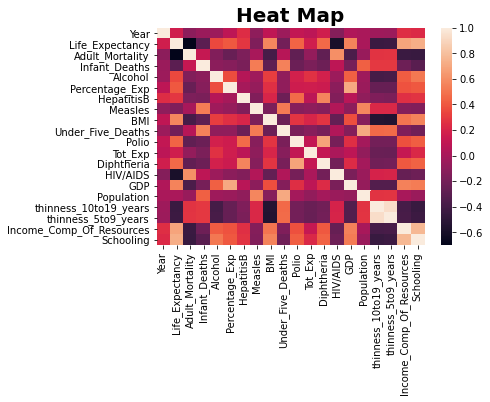

In [50]:
corr = lifeExpec.corr()
ax = plt.axes()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
ax.set_title("Heat Map",fontsize = 20,fontweight='bold')

From the heat map above, we could see life Expectancy has negative correlation with Adult_Mortality, Infant_Deaths, Measles, HIV/AIDS, under-five-year death, thinness 1-19 years, thinness 5-9 years. Life Expectancy has positive correlation with alcohol, percentage_Exp, BMI,Diphtheria,GDP,income_comp_Of_Resource, and Schoolng. For poio, population, the correlation is so small, we could not say it's negative or positive. It worth to mention that life expectancy has high correlation with adult_mortality, BMI, Diphtheria, HIV/AIDS,thinness_1-19_years, thiness_5_to_9_years, income_of_resource and schooling. Further analysis is needed to gain more information.

In [51]:
## divide country into developed and developing counties
lifeExpecDevelping = lifeExpec[lifeExpec["Status"] == "Developing"]
lifeExpecDevelped = lifeExpec[lifeExpec["Status"] == "Developed"]
lifeExpecDevelping.shape

(2080, 22)

In [52]:
developing2000 = lifeExpecDevelping[lifeExpecDevelping['Year'] == 2000]['Life_Expectancy'].mean()
developing2015 = lifeExpecDevelping[lifeExpecDevelping['Year'] == 2015]['Life_Expectancy'].mean()
developing2015 - developing2000

6.3661870503596845

In [53]:
developed2014 = lifeExpecDevelped[lifeExpecDevelped['Year'] == 2014]['Life_Expectancy'].mean()
developed2000 = lifeExpecDevelped[lifeExpecDevelped['Year'] == 2000]['Life_Expectancy'].mean()
developed2014 - developed2000

4.340909090909122

The lifespan increases by 6.36 years for developing countries, while for developed countries, it increases by 4.34 years. Note, for developed countries, because the data in 2015 is missing, we are calculating the life expectancy from 2000 to 2014.

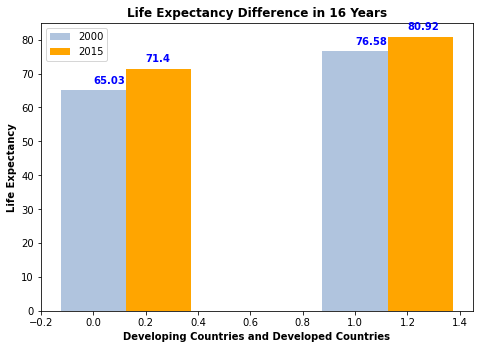

In [54]:
X = np.arange(2)
d1 = [round(developing2000,2),round(developed2000,2)]
d2 = [round(developing2015,2),round(developed2014,2)]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, d1, color = 'lightsteelblue', width = 0.25)
ax.bar(X + 0.25, d2, color = 'orange', width = 0.25)
ax.legend(labels=['2000', '2015'])
ax.set_ylabel("Life Expectancy",fontweight = 'bold')
ax.set_xlabel("Developing Countries and Developed Countries",fontweight = 'bold')
plt.text( 0.0005, d1[0]+2,str(d1[0]), color='blue', fontweight='bold' )
plt.text( 0.2005, d2[0]+2,str(d2[0]), color='blue', fontweight='bold' )
plt.text( 1.0, d1[1]+2,str(d1[1]), color='blue', fontweight='bold' )
plt.text( 1.2005, d2[1]+2,str(d2[1]), color='blue', fontweight='bold' )
plt.title("Life Expectancy Difference in 16 Years", fontweight = 'bold')
plt.show()

The life expectancy in both developing countries and developed countries are both increased. From the figure above we can see that lifespan in developed countries increased by 4.34 years, while those in developing countries increased by 6.37 years.

Next we will investigate factors one by one, to see which factor will affect life expectancy and how it will affect. To dive more, the factors will be divided into immunization factors, mortality factors, economic factors, social factors and other health related factors.


### Mortality Factor
- Adult mortality
- Infant death
- Under_Five_Deaths

In [55]:
lifeExpec['Life_Expectancy'].corr(lifeExpec['Adult_Mortality'])

-0.7028445867028081

Text(0.5, 1.0, 'Life Expectancy vs Adult Mortality')

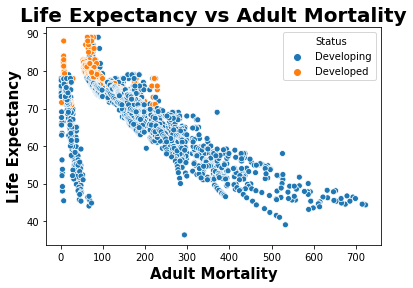

In [56]:
ax = plt.axes()
sns.scatterplot(data = lifeExpec, y = lifeExpec['Life_Expectancy'], x = lifeExpec['Adult_Mortality'],hue = "Status")
plt.ylabel('Life Expectancy', fontsize = 15,fontweight='bold')
plt.xlabel('Adult Mortality', fontsize = 15,fontweight='bold')
ax.set_title("Life Expectancy vs Adult Mortality",  fontsize = 20,fontweight='bold')

In [57]:
lifeExpecDevelped['Life_Expectancy'].corr(lifeExpecDevelped['Adult_Mortality'])

-0.4799820749990814

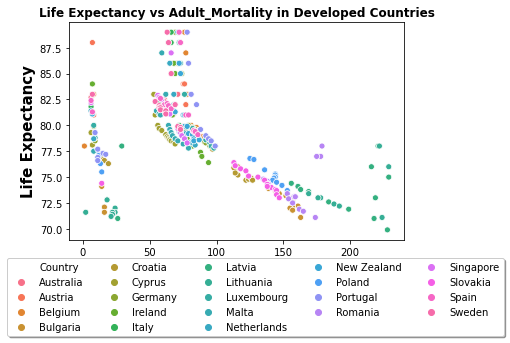

In [58]:
ax = plt.axes()
sns.scatterplot(data = lifeExpecDevelped, y = lifeExpecDevelped['Life_Expectancy'], x = lifeExpecDevelped['Adult_Mortality'],hue = "Country")
plt.ylabel('Life Expectancy', fontsize = 15,fontweight='bold')
plt.xlabel('Adult_Mortality', fontsize = 15,fontweight='bold')
ax.set_title("Life Expectancy vs Adult_Mortality in Developed Countries",  fontsize = 12,fontweight='bold')

plt.legend(loc='upper left', bbox_to_anchor=(-0.2, -0.06),fancybox=True, shadow=True, ncol=5)

In [59]:
lifeExpecDevelping['Life_Expectancy'].corr(lifeExpecDevelping['Adult_Mortality'])

-0.6813495919717263

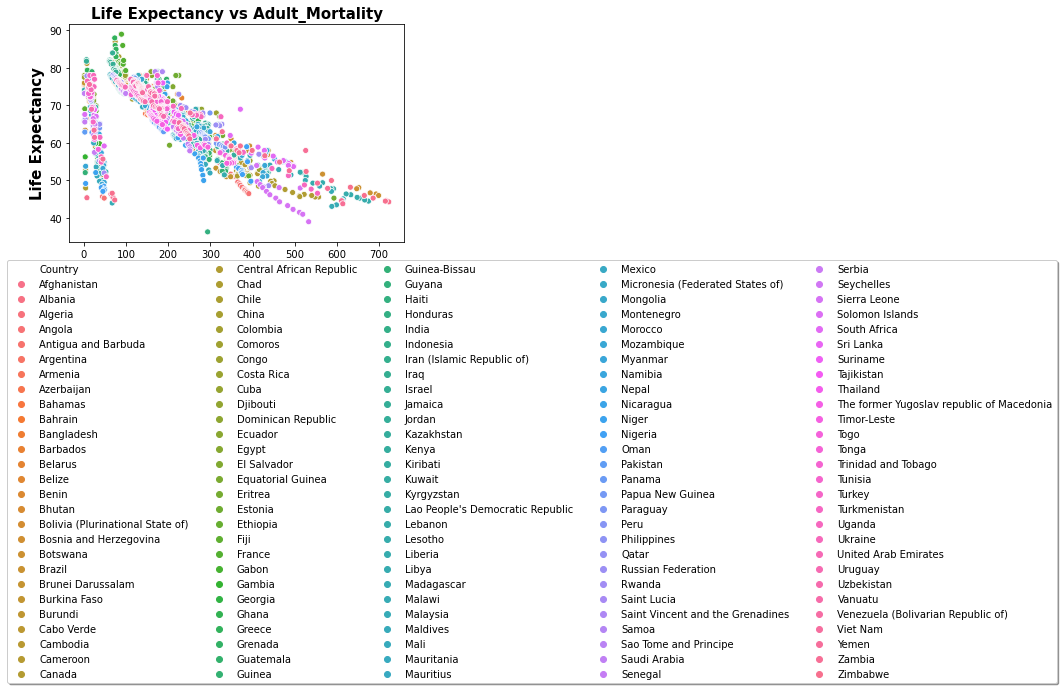

In [60]:
ax = plt.axes()
sns.scatterplot(data = lifeExpecDevelping, y = lifeExpecDevelping['Life_Expectancy'], x = lifeExpecDevelping['Adult_Mortality'],hue = "Country")
plt.ylabel('Life Expectancy', fontsize = 15,fontweight='bold')
plt.xlabel('Adult_Mortality', fontsize = 15,fontweight='bold')
ax.set_title("Life Expectancy vs Adult_Mortality",  fontsize = 15,fontweight='bold')

plt.legend(loc='upper left', bbox_to_anchor=(-0.2, -0.06),fancybox=True, shadow=True, ncol=5)

Above, the pearson correlation is used to test the correlation between Life Expectancy and Adult Mortality. The correlation is -0.7028. That means, the higher the mortality in a country, the shorter life expectancy. This applies to both developed countries and developing countries.

In [61]:
lifeExpec['Life_Expectancy'].corr(lifeExpec['Infant_Deaths'])

-0.30072840781414983

Text(0.5, 1.0, 'Life Expectancy vs Infant Death')

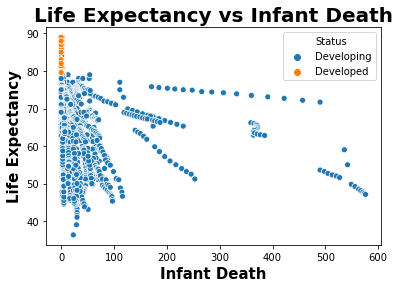

In [62]:
ax = plt.axes()
sns.scatterplot(data = lifeExpec, y = lifeExpec['Life_Expectancy'], x = lifeExpec['Infant_Deaths'],hue = "Status")
plt.ylabel('Life Expectancy', fontsize = 15,fontweight='bold')
plt.xlabel('Infant Death', fontsize = 15,fontweight='bold')
ax.set_title("Life Expectancy vs Infant Death",  fontsize = 20,fontweight='bold')

From above analysis, the correlation between life Expectancy and Infant Death is relatively low, -0.3007. That means, the higher life expectancy, the relatively lower infant death rate. But the correlation is low. There is an interesting phenomenia observed from correlation graph. For developed country, there is almost no relationship between life expectancy and infant death. Only for developing country the infant death may have low relationship with life expectancy. Further analysis are done below.

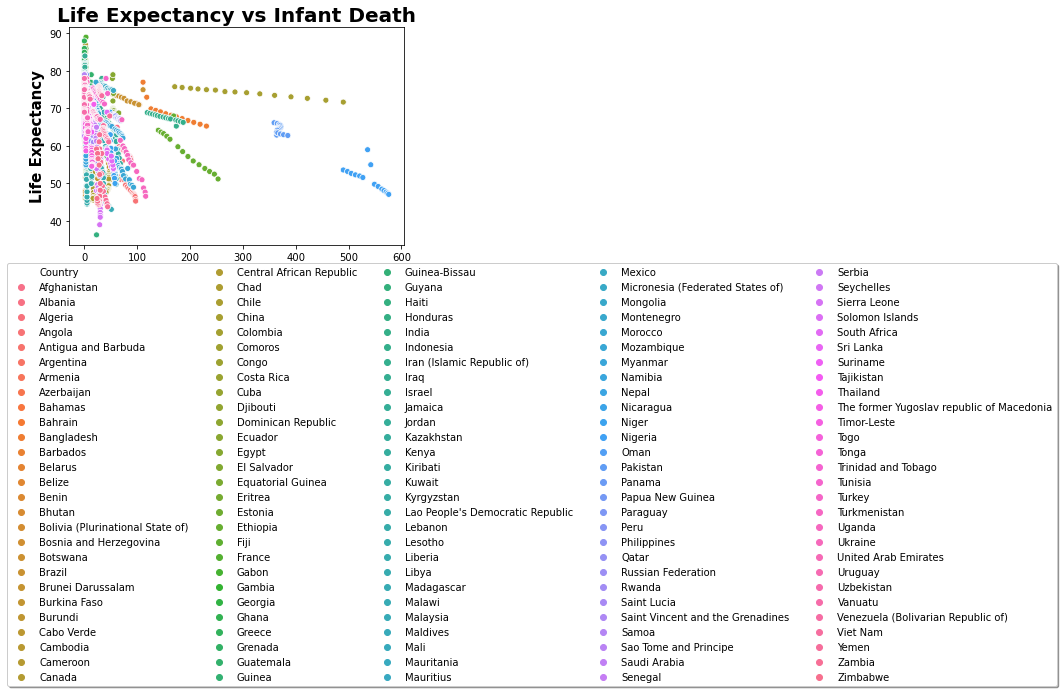

In [63]:
ax = plt.axes()
sns.scatterplot(data = lifeExpecDevelping, y = lifeExpecDevelping['Life_Expectancy'], x = lifeExpecDevelping['Infant_Deaths'],hue = "Country")
plt.ylabel('Life Expectancy', fontsize = 15,fontweight='bold')
plt.xlabel('Infant Death', fontsize = 15,fontweight='bold')
ax.set_title("Life Expectancy vs Infant Death",  fontsize = 20,fontweight='bold')

plt.legend(loc='upper left', bbox_to_anchor=(-0.2, -0.06),fancybox=True, shadow=True, ncol=5)

In [64]:
lifeExpecDevelping['Life_Expectancy'].corr(lifeExpecDevelping['Infant_Deaths'])

-0.27211689706120556

In [65]:
lifeExpecDevelped['Life_Expectancy'].corr(lifeExpecDevelped['Infant_Deaths'])

-0.07492971195058892

Indeed, some countries, the life expectancy has high correlation with infant death. For these country, lower the infant death could be one factor increase the whole country life expectancy.

In [66]:
lifeExpec['Life_Expectancy'].corr(lifeExpec['Under_Five_Deaths'])

-0.20293222227457036

Text(0.5, 1.0, 'Life Expectancy vs Under Five Deaths')

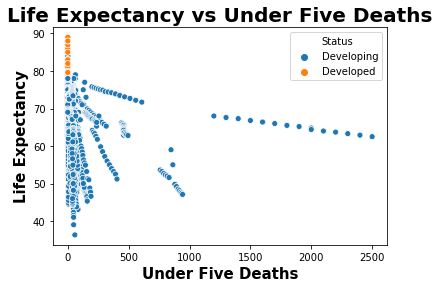

In [67]:
ax = plt.axes()
sns.scatterplot(data = lifeExpec, y = lifeExpec['Life_Expectancy'], x = lifeExpec['Under_Five_Deaths'],hue = "Status")
plt.ylabel('Life Expectancy', fontsize = 15,fontweight='bold')
plt.xlabel('Under Five Deaths', fontsize = 15,fontweight='bold')
ax.set_title("Life Expectancy vs Under Five Deaths",  fontsize = 20,fontweight='bold')

In [68]:
lifeExpecDevelping['Life_Expectancy'].corr(lifeExpecDevelping['Under_Five_Deaths'])

-0.18168016593909464

In [69]:
lifeExpecDevelped['Life_Expectancy'].corr(lifeExpecDevelped['Under_Five_Deaths'])

-0.046446267100599514

There is very low relationship with life expectancy and under five death. For developed countries, there is no correlation between life expectancy and under five death.

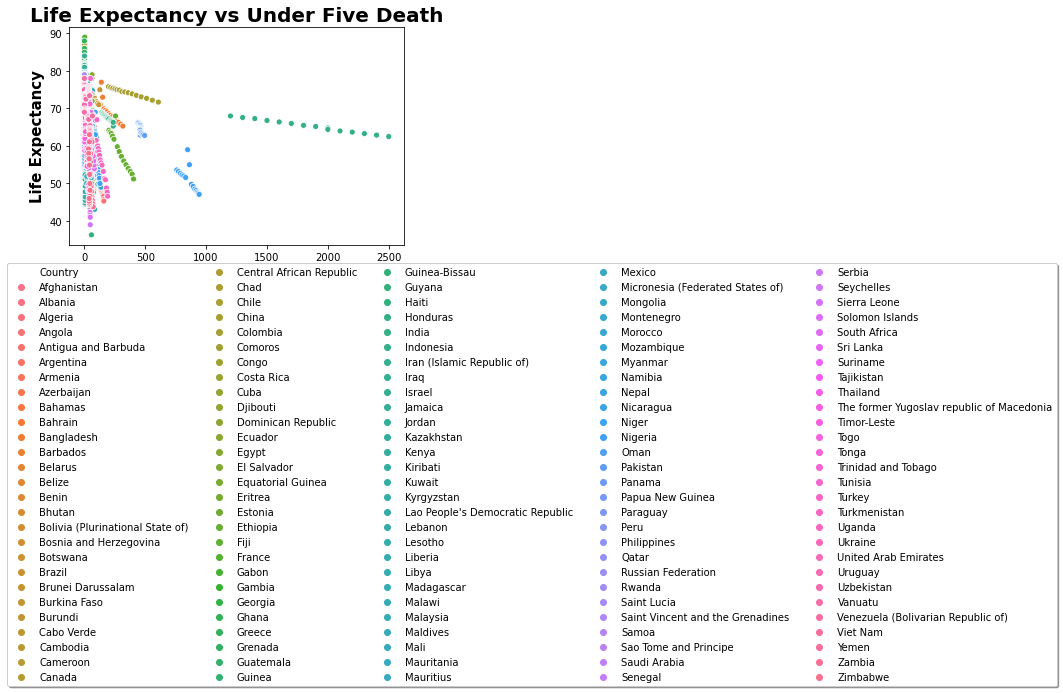

In [70]:
ax = plt.axes()
sns.scatterplot(data = lifeExpecDevelping, y = lifeExpecDevelping['Life_Expectancy'], x = lifeExpecDevelping['Under_Five_Deaths'],hue = "Country")
plt.ylabel('Life Expectancy', fontsize = 15,fontweight='bold')
plt.xlabel('Under Five Death', fontsize = 15,fontweight='bold')
ax.set_title("Life Expectancy vs Under Five Death",  fontsize = 20,fontweight='bold')

plt.legend(loc='upper left', bbox_to_anchor=(-0.2, -0.06),fancybox=True, shadow=True, ncol=5)

Only for a few counties, life expectancy and under five death have higher correlations. For these countries, lower the under five death could improve the life expectancy. We can do further analysis on these countries.


### Immunization Factors
- HepatitisB
- Polio
- Diphtheria

In [71]:
lifeExpec['Life_Expectancy'].corr(lifeExpec['HepatitisB'])

0.28371010671292163

Text(0.5, 1.0, 'Life Expectancy vs HepatitisB')

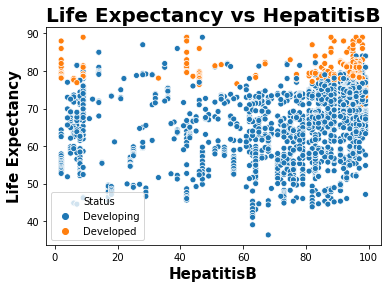

In [72]:
ax = plt.axes()
sns.scatterplot(data = lifeExpec, y = lifeExpec['Life_Expectancy'], x = lifeExpec['HepatitisB'],hue = "Status")
plt.ylabel('Life Expectancy', fontsize = 15,fontweight='bold')
plt.xlabel('HepatitisB', fontsize = 15,fontweight='bold')
ax.set_title("Life Expectancy vs HepatitisB",  fontsize = 20,fontweight='bold')

In [73]:
lifeExpecDevelped['Life_Expectancy'].corr(lifeExpecDevelped['HepatitisB'])

-0.1853476684251502

In [74]:
lifeExpecDevelping['Life_Expectancy'].corr(lifeExpecDevelping['HepatitisB'])

0.3086335488127775

In [75]:
lifeExpec['Life_Expectancy'].corr(lifeExpec['Polio'])

0.4478834851578934

Text(0.5, 1.0, 'Life Expectancy vs Polio')

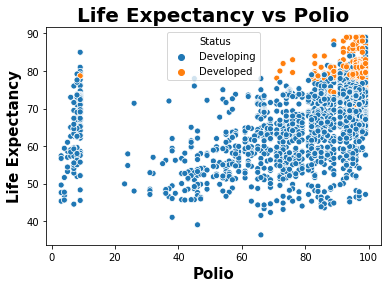

In [76]:
ax = plt.axes()
sns.scatterplot(data = lifeExpec, y = lifeExpec['Life_Expectancy'], x = lifeExpec['Polio'],hue = "Status")
plt.ylabel('Life Expectancy', fontsize = 15,fontweight='bold')
plt.xlabel('Polio', fontsize = 15,fontweight='bold')
ax.set_title("Life Expectancy vs Polio",  fontsize = 20,fontweight='bold')

In [77]:
lifeExpecDevelped['Life_Expectancy'].corr(lifeExpecDevelped['Polio'])

0.03109132846878883

In [78]:
lifeExpecDevelping['Life_Expectancy'].corr(lifeExpecDevelping['Polio'])

0.4190747242357623

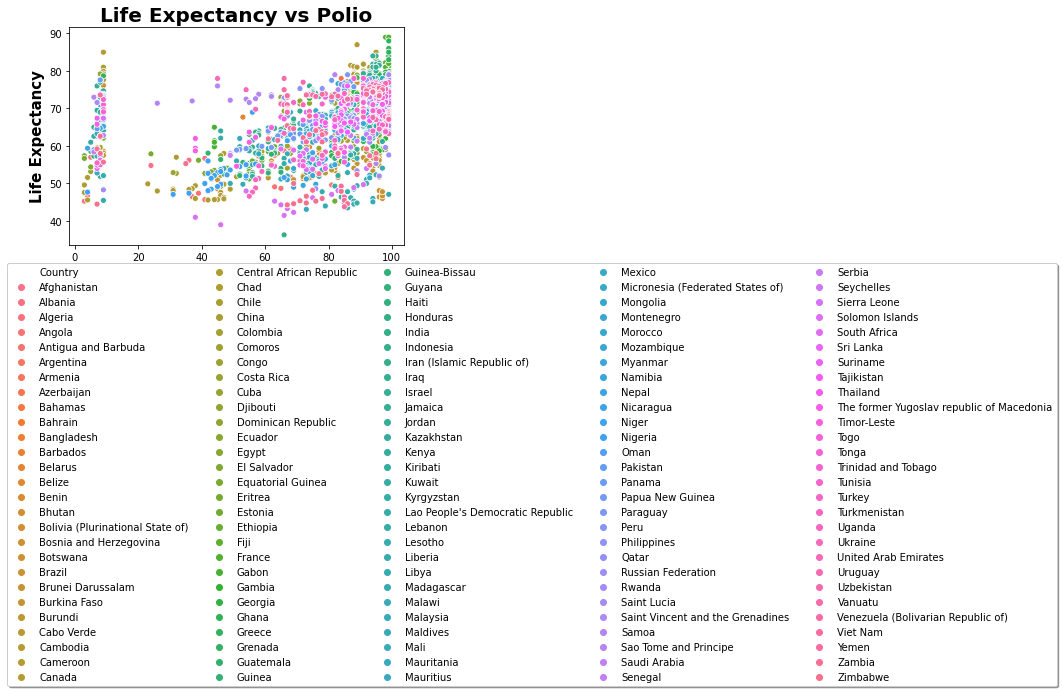

In [79]:
ax = plt.axes()
sns.scatterplot(data = lifeExpecDevelping, y = lifeExpecDevelping['Life_Expectancy'], x = lifeExpecDevelping['Polio'],hue = "Country")
plt.ylabel('Life Expectancy', fontsize = 15,fontweight='bold')
plt.xlabel('Polio', fontsize = 15,fontweight='bold')
ax.set_title("Life Expectancy vs Polio",  fontsize = 20,fontweight='bold')

plt.legend(loc='upper left', bbox_to_anchor=(-0.2, -0.06),fancybox=True, shadow=True, ncol=5)

In [80]:
lifeExpec['Life_Expectancy'].corr(lifeExpec['Diphtheria'])

0.46693551383309634

Text(0.5, 1.0, 'Life Expectancy vs Diphtheria')

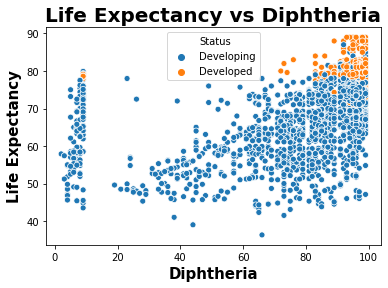

In [81]:
ax = plt.axes()
sns.scatterplot(data = lifeExpec, y = lifeExpec['Life_Expectancy'], x = lifeExpec['Diphtheria'],hue = "Status")
plt.ylabel('Life Expectancy', fontsize = 15,fontweight='bold')
plt.xlabel('Diphtheria', fontsize = 15,fontweight='bold')
ax.set_title("Life Expectancy vs Diphtheria",  fontsize = 20,fontweight='bold')

In [82]:
lifeExpecDevelped['Life_Expectancy'].corr(lifeExpecDevelped['Diphtheria'])

-0.007436451781031039

In [83]:
lifeExpecDevelping['Life_Expectancy'].corr(lifeExpecDevelping['Diphtheria'])

0.45340852569448836

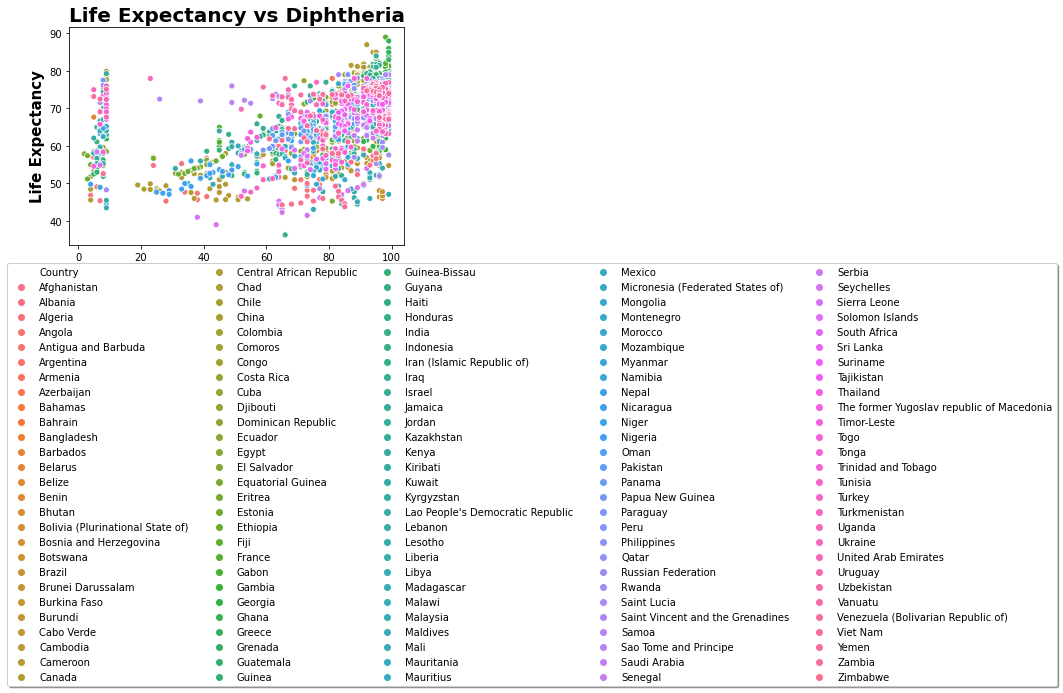

In [84]:
ax = plt.axes()
sns.scatterplot(data = lifeExpecDevelping, y = lifeExpecDevelping['Life_Expectancy'], x = lifeExpecDevelping['Diphtheria'],hue = "Country")
plt.ylabel('Life Expectancy', fontsize = 15,fontweight='bold')
plt.xlabel('Polio', fontsize = 15,fontweight='bold')
ax.set_title("Life Expectancy vs Diphtheria",  fontsize = 20,fontweight='bold')

plt.legend(loc='upper left', bbox_to_anchor=(-0.2, -0.06),fancybox=True, shadow=True, ncol=5)

### Economic Factors
 - Percentage_Exp
 - Tot_Exp
 - GDP
 - Income_Comp_Of_Resources

In [87]:
lifeExpec['Life_Expectancy'].corr(lifeExpec['Percentage_Exp'])

0.4046144562099111

Text(0.5, 1.0, 'Life Expectancy vs Percentage Expenditure')

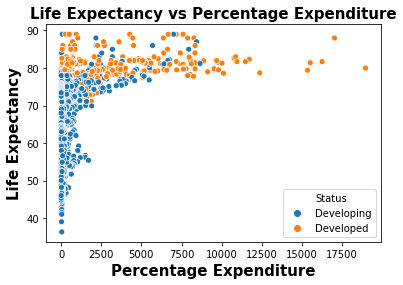

In [88]:
ax = plt.axes()
sns.scatterplot(data = lifeExpec, y = lifeExpec['Life_Expectancy'], x = lifeExpec['Percentage_Exp'],hue = "Status")
plt.ylabel('Life Expectancy', fontsize = 15,fontweight='bold')
plt.xlabel('Percentage Expenditure', fontsize = 15,fontweight='bold')
ax.set_title("Life Expectancy vs Percentage Expenditure",  fontsize = 15,fontweight='bold')

In [89]:
lifeExpecDevelped['Life_Expectancy'].corr(lifeExpecDevelped['Percentage_Exp'])

0.40277100295503654

In [90]:
lifeExpec['Life_Expectancy'].corr(lifeExpec['Tot_Exp'])

0.16856648640209512

Text(0.5, 1.0, 'Life Expectancy vs Total Expenditure')

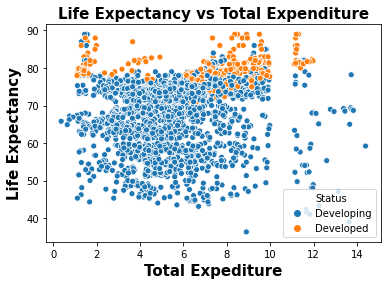

In [91]:
ax = plt.axes()
sns.scatterplot(data = lifeExpec, y = lifeExpec['Life_Expectancy'], x = lifeExpec['Tot_Exp'],hue = "Status")
plt.ylabel('Life Expectancy', fontsize = 15,fontweight='bold')
plt.xlabel('Total Expediture', fontsize = 15,fontweight='bold')
ax.set_title("Life Expectancy vs Total Expenditure",  fontsize = 15,fontweight='bold')

In [92]:
lifeExpecDevelped['Life_Expectancy'].corr(lifeExpecDevelped['Tot_Exp'])

0.15034523637417097

In [93]:
lifeExpecDevelping['Life_Expectancy'].corr(lifeExpecDevelping['Tot_Exp'])

0.078351517530003

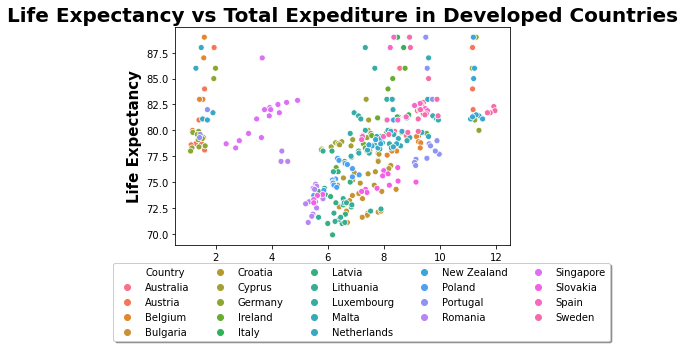

In [94]:
ax = plt.axes()
sns.scatterplot(data = lifeExpecDevelped, y = lifeExpecDevelped['Life_Expectancy'], x = lifeExpecDevelped['Tot_Exp'],hue = "Country")
plt.ylabel('Life Expectancy', fontsize = 15,fontweight='bold')
plt.xlabel('Total Expediture', fontsize = 15,fontweight='bold')
ax.set_title("Life Expectancy vs Total Expediture in Developed Countries",  fontsize = 20,fontweight='bold')
plt.legend(loc='upper left', bbox_to_anchor=(-0.2, -0.06),fancybox=True, shadow=True, ncol=5)

In [95]:
lifeExpec['Life_Expectancy'].corr(lifeExpec['GDP'])

0.5604577174382323

Text(0.5, 1.0, 'Life Expectancy vs GDP')

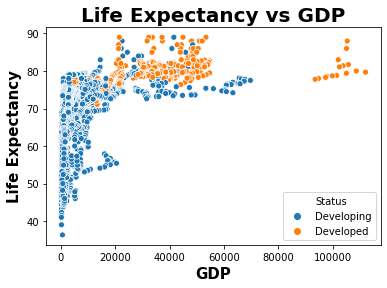

In [96]:
ax = plt.axes()
sns.scatterplot(data = lifeExpec, y = lifeExpec['Life_Expectancy'], x = lifeExpec['GDP'],hue = "Status")
plt.ylabel('Life Expectancy', fontsize = 15,fontweight='bold')
plt.xlabel('GDP', fontsize = 15,fontweight='bold')
ax.set_title("Life Expectancy vs GDP",  fontsize = 20,fontweight='bold')

In [97]:
lifeExpecDevelped['Life_Expectancy'].corr(lifeExpecDevelped['GDP'])

0.5902593874691077

In [98]:
lifeExpecDevelping['Life_Expectancy'].corr(lifeExpecDevelping['GDP'])

0.46697167697892705

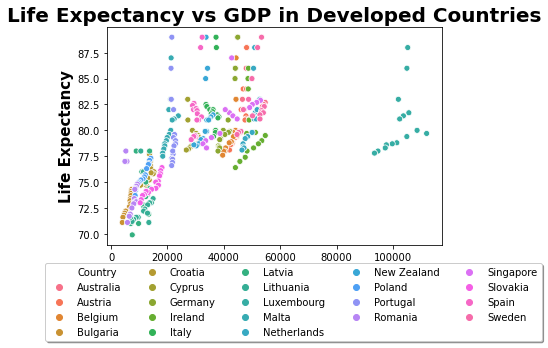

In [99]:
ax = plt.axes()
sns.scatterplot(data = lifeExpecDevelped, y = lifeExpecDevelped['Life_Expectancy'], x = lifeExpecDevelped['GDP'],hue = "Country")
plt.ylabel('Life Expectancy', fontsize = 15,fontweight='bold')
plt.xlabel('GDP', fontsize = 15,fontweight='bold')
ax.set_title("Life Expectancy vs GDP in Developed Countries",  fontsize = 20,fontweight='bold')
plt.legend(loc='upper left', bbox_to_anchor=(-0.2, -0.06),fancybox=True, shadow=True, ncol=5)

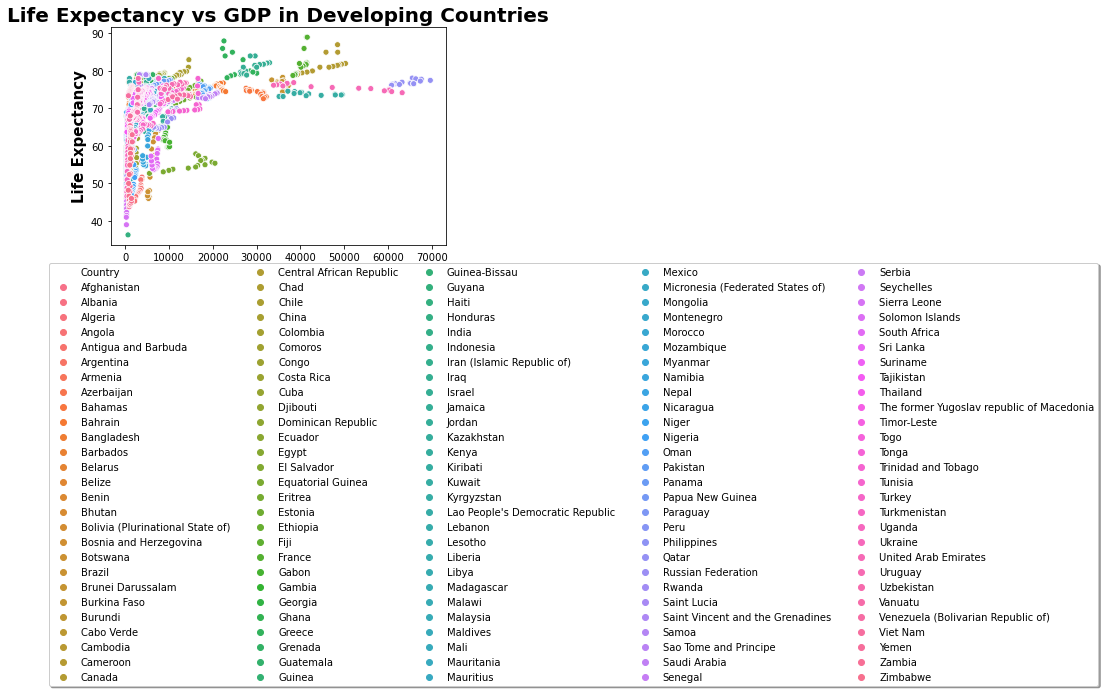

In [100]:
ax = plt.axes()
sns.scatterplot(data = lifeExpecDevelping, y = lifeExpecDevelping['Life_Expectancy'], x= lifeExpecDevelping['GDP'],hue = "Country")
plt.ylabel('Life Expectancy', fontsize = 15,fontweight='bold')
plt.xlabel('GDP', fontsize = 15,fontweight='bold')
ax.set_title("Life Expectancy vs GDP in Developing Countries",  fontsize = 20,fontweight='bold')
plt.legend(loc='upper left', bbox_to_anchor=(-0.2, -0.06),fancybox=True, shadow=True, ncol=5)

In [101]:
lifeExpec['Life_Expectancy'].corr(lifeExpec['Income_Comp_Of_Resources'])

0.6936189219089646

Text(0.5, 1.0, 'Life Expectancy vs Income Composition of Resources')

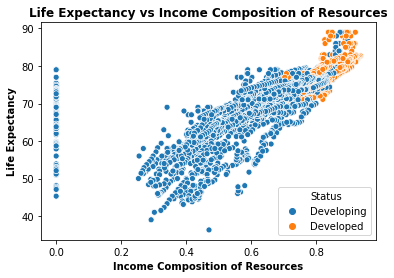

In [102]:
ax = plt.axes()
sns.scatterplot(data = lifeExpec, y= lifeExpec['Life_Expectancy'],x = lifeExpec['Income_Comp_Of_Resources'],hue = "Status")
plt.ylabel('Life Expectancy', fontsize = 10,fontweight='bold')
plt.xlabel('Income Composition of Resources', fontsize = 10,fontweight='bold')
ax.set_title("Life Expectancy vs Income Composition of Resources",  fontsize = 12,fontweight='bold')

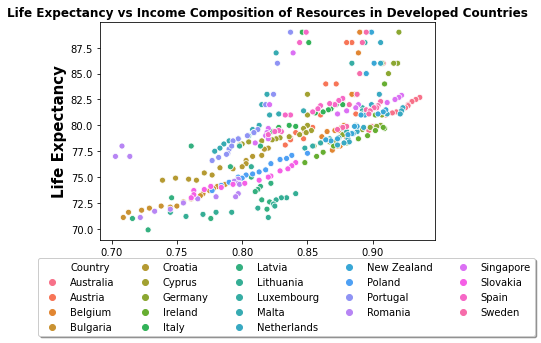

In [103]:
ax = plt.axes()
sns.scatterplot(data = lifeExpecDevelped, y = lifeExpecDevelped['Life_Expectancy'], x = lifeExpecDevelped['Income_Comp_Of_Resources'],hue = "Country")
plt.ylabel('Life Expectancy', fontsize = 15,fontweight='bold')
plt.xlabel('Income Composition of Resources', fontsize = 15,fontweight='bold')
ax.set_title("Life Expectancy vs Income Composition of Resources in Developed Countries",  fontsize = 12,fontweight='bold')
plt.legend(loc='upper left', bbox_to_anchor=(-0.2, -0.06),fancybox=True, shadow=True, ncol=5)

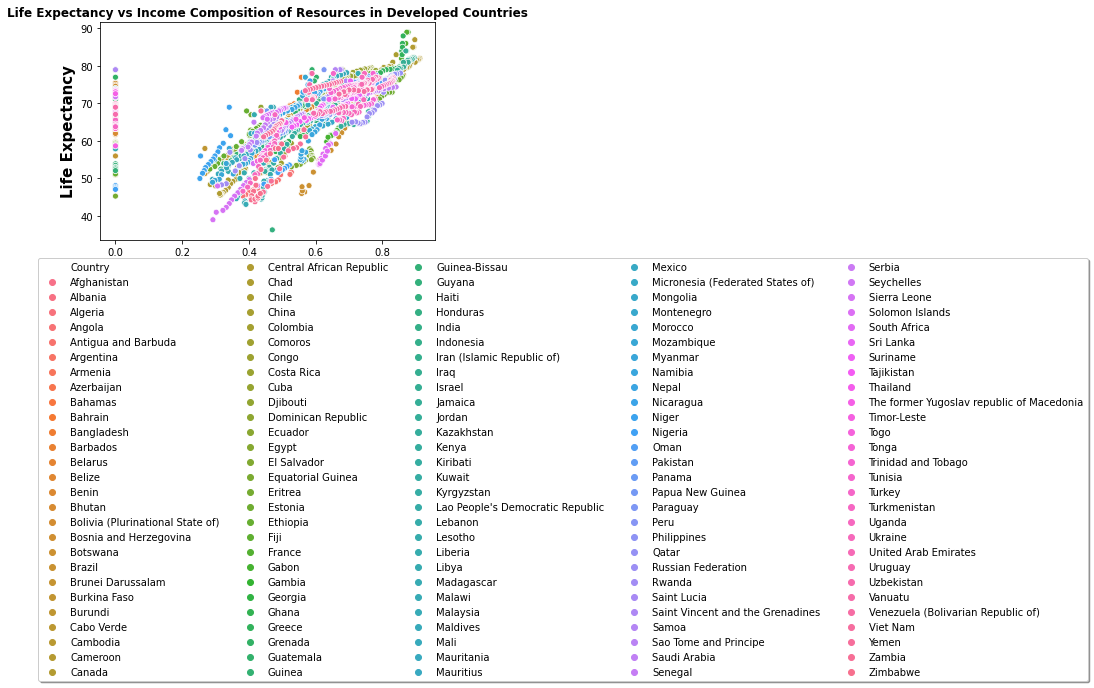

In [104]:
ax = plt.axes()
sns.scatterplot(data = lifeExpecDevelping, y = lifeExpecDevelping['Life_Expectancy'], x = lifeExpecDevelping['Income_Comp_Of_Resources'],hue = "Country")
plt.ylabel('Life Expectancy', fontsize = 15,fontweight='bold')
plt.xlabel('Income Composition of Resources', fontsize = 15,fontweight='bold')
ax.set_title("Life Expectancy vs Income Composition of Resources in Developed Countries",  fontsize = 12,fontweight='bold')
plt.legend(loc='upper left', bbox_to_anchor=(-0.2, -0.06),fancybox=True, shadow=True, ncol=5)

In [105]:
lifeExpecDevelped['Life_Expectancy'].corr(lifeExpecDevelped['Income_Comp_Of_Resources'])

0.7240377050245497

In [106]:
lifeExpecDevelping['Life_Expectancy'].corr(lifeExpecDevelping['Income_Comp_Of_Resources'])

0.6240240378189589

### Social factors
- schooling
- Population

In [107]:
lifeExpec['Life_Expectancy'].corr(lifeExpec['Schooling'])

0.7336048712147273

Text(0.5, 1.0, 'Life Expectancy vs Schooling')

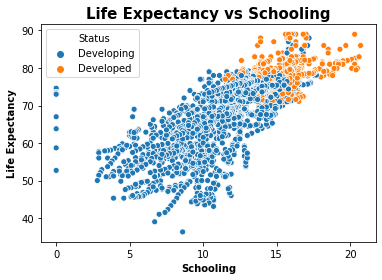

In [108]:
ax = plt.axes()
sns.scatterplot(data = lifeExpec, y= lifeExpec['Life_Expectancy'],x = lifeExpec['Schooling'],hue = "Status")
plt.ylabel('Life Expectancy', fontsize = 10,fontweight='bold')
plt.xlabel('Schooling', fontsize = 10,fontweight='bold')
ax.set_title("Life Expectancy vs Schooling",  fontsize = 15,fontweight='bold')

In [109]:
lifeExpecDevelped['Life_Expectancy'].corr(lifeExpecDevelped['Schooling'])

0.3826873649636899

In [110]:
lifeExpecDevelping['Life_Expectancy'].corr(lifeExpecDevelping['Schooling'])

0.6808867178385944

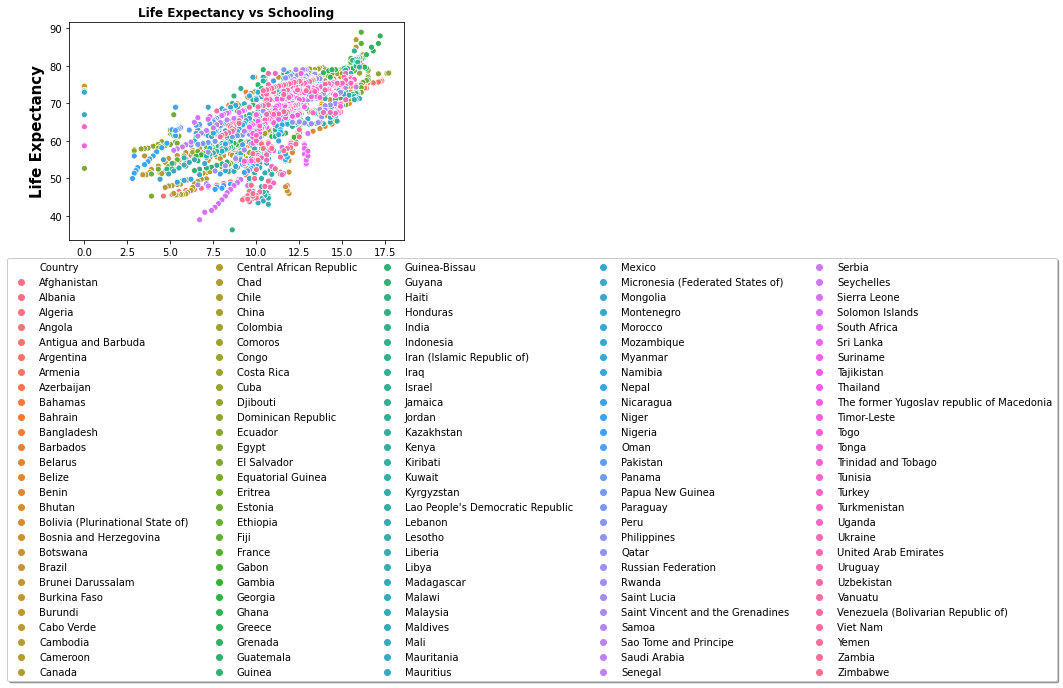

In [111]:
ax = plt.axes()
sns.scatterplot(data = lifeExpecDevelping, y = lifeExpecDevelping['Life_Expectancy'], x = lifeExpecDevelping['Schooling'],hue = "Country")
plt.ylabel('Life Expectancy', fontsize = 15,fontweight='bold')
plt.xlabel('Schooling', fontsize = 15,fontweight='bold')
ax.set_title("Life Expectancy vs Schooling",  fontsize = 12,fontweight='bold')
plt.legend(loc='upper left', bbox_to_anchor=(-0.2, -0.06),fancybox=True, shadow=True, ncol=5)

In [112]:
lifeExpec['Life_Expectancy'].corr(lifeExpec['Population'])

0.013048459586362375

Text(0.5, 1.0, 'Life Expectancy vs Population')

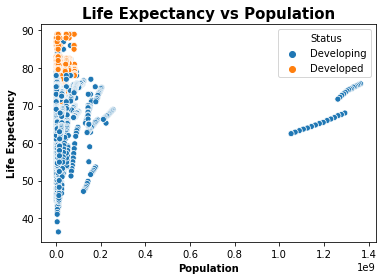

In [113]:
ax = plt.axes()
sns.scatterplot(data = lifeExpec, y= lifeExpec['Life_Expectancy'],x = lifeExpec['Population'],hue = "Status")
plt.ylabel('Life Expectancy', fontsize = 10,fontweight='bold')
plt.xlabel('Population', fontsize = 10,fontweight='bold')
ax.set_title("Life Expectancy vs Population",  fontsize = 15,fontweight='bold')

In [114]:
lifeExpecDevelped['Life_Expectancy'].corr(lifeExpecDevelped['Population'])

0.21012123801021867

In [115]:
lifeExpecDevelping['Life_Expectancy'].corr(lifeExpecDevelping['Population'])

0.04027574734935439

### Other Health Related Factors
- Alcohol
- BMI
- thinness_1to19_years
- thinness_5to9_years
- HIV/AIDS
- Measles

In [138]:
lifeExpec['Life_Expectancy'].corr(lifeExpec['Measles'])

-0.1512301020702818

In [139]:
lifeExpecDevelped['Life_Expectancy'].corr(lifeExpecDevelped['Measles'])

-0.05078699602836095

In [140]:
lifeExpecDevelping['Life_Expectancy'].corr(lifeExpecDevelping['Measles'])

-0.13596003298456444

Text(0.5, 1.0, 'Life Expectancy vs Alcohol')

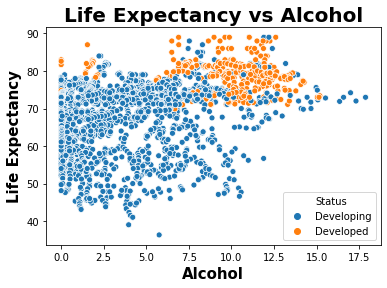

In [141]:
ax = plt.axes()
sns.scatterplot(data = lifeExpec, y = lifeExpec['Life_Expectancy'], x = lifeExpec['Alcohol'],hue = "Status")
plt.ylabel('Life Expectancy', fontsize = 15,fontweight='bold')
plt.xlabel('Alcohol', fontsize = 15,fontweight='bold')
ax.set_title("Life Expectancy vs Alcohol",  fontsize = 20,fontweight='bold')

In [142]:
lifeExpecDevelped['Life_Expectancy'].corr(lifeExpecDevelped['Alcohol'])

-0.20407095274156897

In [143]:
lifeExpecDevelping['Life_Expectancy'].corr(lifeExpecDevelping['Alcohol'])

0.17239461539516923

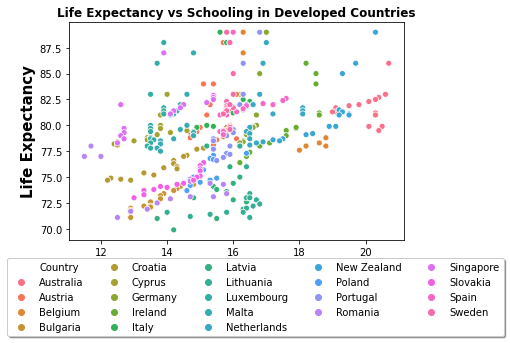

In [144]:
ax = plt.axes()
sns.scatterplot(data = lifeExpecDevelped, y = lifeExpecDevelped['Life_Expectancy'], x = lifeExpecDevelped['Schooling'],hue = "Country")
plt.ylabel('Life Expectancy', fontsize = 15,fontweight='bold')
plt.xlabel('Schooling', fontsize = 15,fontweight='bold')
ax.set_title("Life Expectancy vs Schooling in Developed Countries",  fontsize = 12,fontweight='bold')
plt.legend(loc='upper left', bbox_to_anchor=(-0.2, -0.06),fancybox=True, shadow=True, ncol=5)

In [145]:
lifeExpec['Life_Expectancy'].corr(lifeExpec['BMI'])

0.5722808697013191

Text(0.5, 1.0, 'Life Expectancy vs BMI')

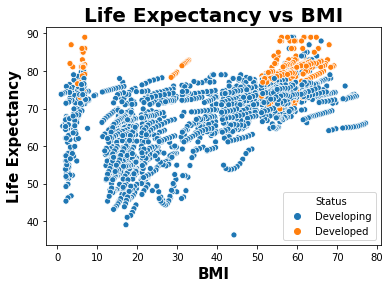

In [146]:
ax = plt.axes()
sns.scatterplot(data = lifeExpec, y = lifeExpec['Life_Expectancy'], x = lifeExpec['BMI'],hue = "Status")
plt.ylabel('Life Expectancy', fontsize = 15,fontweight='bold')
plt.xlabel('BMI', fontsize = 15,fontweight='bold')
ax.set_title("Life Expectancy vs BMI",  fontsize = 20,fontweight='bold')

In [147]:
lifeExpecDevelping['Life_Expectancy'].corr(lifeExpecDevelping['BMI'])

0.5626730056861268

In [148]:
lifeExpecDevelped['Life_Expectancy'].corr(lifeExpecDevelped['BMI'])

-0.006094497369848113

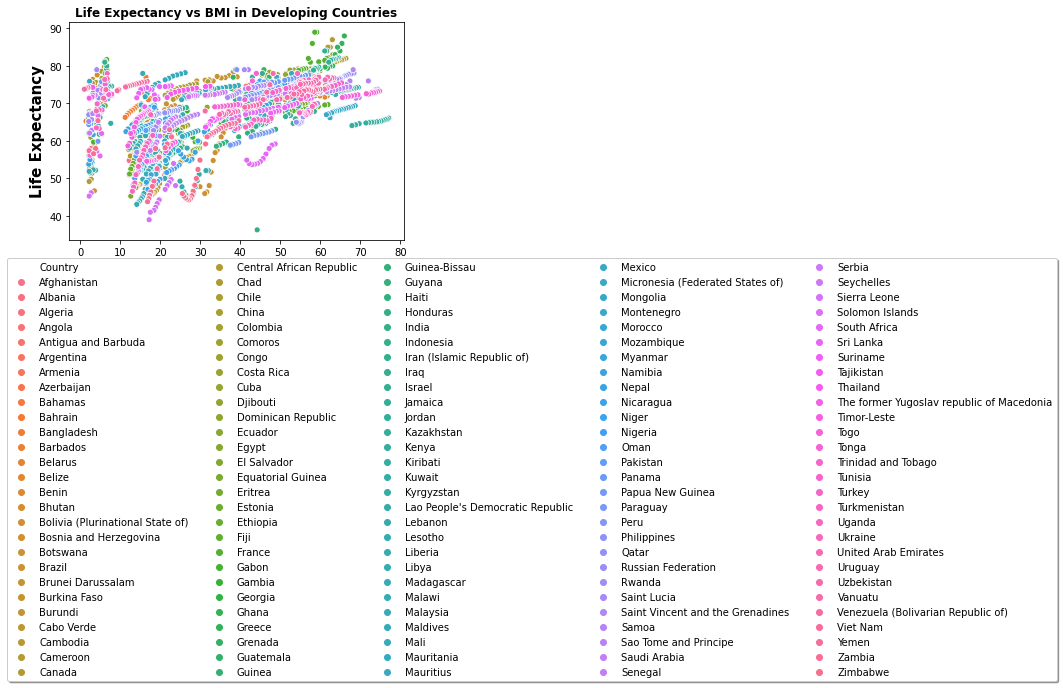

In [149]:
ax = plt.axes()
sns.scatterplot(data = lifeExpecDevelping, y = lifeExpecDevelping['Life_Expectancy'], x = lifeExpecDevelping['BMI'],hue = "Country")
plt.ylabel('Life Expectancy', fontsize = 15,fontweight='bold')
plt.xlabel('BMI', fontsize = 15,fontweight='bold')
ax.set_title("Life Expectancy vs BMI in Developing Countries",  fontsize = 12,fontweight='bold')
plt.legend(loc='upper left', bbox_to_anchor=(-0.2, -0.06),fancybox=True, shadow=True, ncol=5)

In [150]:
lifeExpec['Life_Expectancy'].corr(lifeExpec['thinness_10to19_years'])

-0.442014798070637

Text(0.5, 1.0, 'Life Expectancy vs thinness 10 to 19 years')

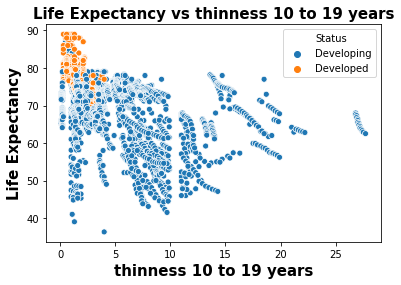

In [151]:
ax = plt.axes()
sns.scatterplot(data = lifeExpec, y = lifeExpec['Life_Expectancy'], x = lifeExpec['thinness_10to19_years'],hue = "Status")
plt.ylabel('Life Expectancy', fontsize = 15,fontweight='bold')
plt.xlabel('thinness 10 to 19 years', fontsize = 15,fontweight='bold')
ax.set_title("Life Expectancy vs thinness 10 to 19 years",  fontsize = 15,fontweight='bold')

In [152]:
lifeExpecDevelped['Life_Expectancy'].corr(lifeExpecDevelped['thinness_10to19_years'])

-0.6152969464491912

In [153]:
lifeExpecDevelping['Life_Expectancy'].corr(lifeExpecDevelping['thinness_10to19_years'])

-0.35332547973205

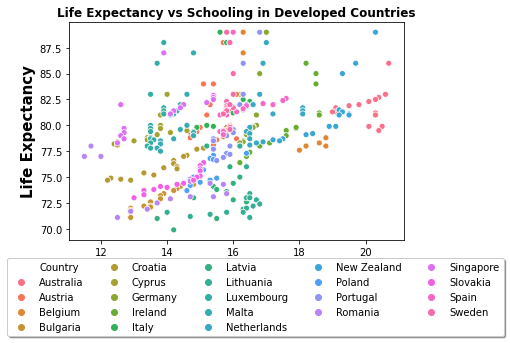

In [154]:
ax = plt.axes()
sns.scatterplot(data = lifeExpecDevelped, y = lifeExpecDevelped['Life_Expectancy'], x = lifeExpecDevelped['Schooling'],hue = "Country")
plt.ylabel('Life Expectancy', fontsize = 15,fontweight='bold')
plt.xlabel('Schooling', fontsize = 15,fontweight='bold')
ax.set_title("Life Expectancy vs Schooling in Developed Countries",  fontsize = 12,fontweight='bold')
plt.legend(loc='upper left', bbox_to_anchor=(-0.2, -0.06),fancybox=True, shadow=True, ncol=5)

In [155]:
lifeExpec['Life_Expectancy'].corr(lifeExpec['thinness_5to9_years'])

-0.43521407962159886

Text(0.5, 1.0, 'Life Expectancy vs thinness 5 to 9 years')

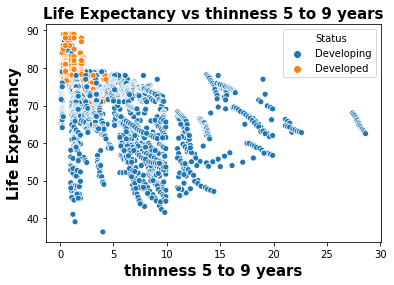

In [156]:
ax = plt.axes()
sns.scatterplot(data = lifeExpec, y = lifeExpec['Life_Expectancy'], x = lifeExpec['thinness_5to9_years'],hue = "Status")
plt.ylabel('Life Expectancy', fontsize = 15,fontweight='bold')
plt.xlabel('thinness 5 to 9 years', fontsize = 15,fontweight='bold')
ax.set_title("Life Expectancy vs thinness 5 to 9 years",  fontsize = 15,fontweight='bold')

In [157]:
lifeExpec['Life_Expectancy'].corr(lifeExpec['HIV/AIDS'])

-0.5890648695404345

Text(0.5, 1.0, 'Life Expectancy vs HIV/AIDS')

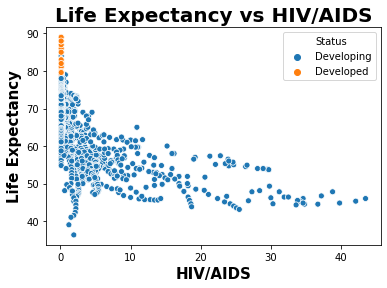

In [158]:
ax = plt.axes()
sns.scatterplot(data = lifeExpec, y = lifeExpec['Life_Expectancy'], x = lifeExpec['HIV/AIDS'],hue = "Status")
plt.ylabel('Life Expectancy', fontsize = 15,fontweight='bold')
plt.xlabel('HIV/AIDS', fontsize = 15,fontweight='bold')
ax.set_title("Life Expectancy vs HIV/AIDS",  fontsize = 20,fontweight='bold')

In [159]:
lifeExpecDevelped['Life_Expectancy'].corr(lifeExpecDevelped['HIV/AIDS'])

2.001504491858226e-15

In [160]:
lifeExpecDevelping['Life_Expectancy'].corr(lifeExpecDevelping['HIV/AIDS'])

-0.6031286231500611

In the next session, we will check if the life expectancy is increased from 2000 to 2015.

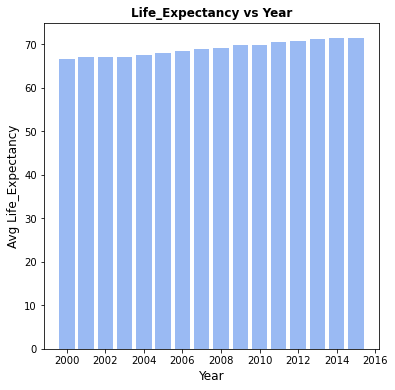

In [161]:
# Life_Expectancy through years
plt.figure(figsize=(6,6))
plt.bar(lifeExpec.groupby('Year')['Year'].count().index,lifeExpec.groupby('Year')['Life_Expectancy'].mean(),color='cornflowerblue',alpha=0.65)
plt.xlabel("Year",fontsize=12)
plt.ylabel("Avg Life_Expectancy",fontsize=12)
plt.title("Life_Expectancy vs Year",fontweight='bold')
plt.show()

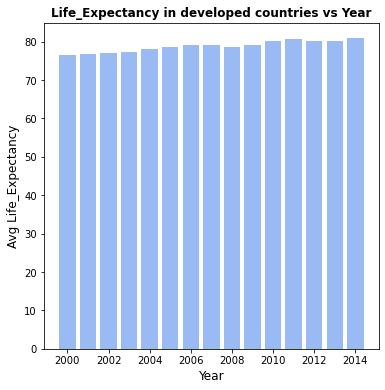

In [162]:
# Life_Expectancy through years
plt.figure(figsize=(6,6))
plt.bar(lifeExpecDevelped.groupby('Year')['Year'].count().index,lifeExpecDevelped.groupby('Year')['Life_Expectancy'].mean(),color='cornflowerblue',alpha=0.65)
plt.xlabel("Year",fontsize=12)
plt.ylabel("Avg Life_Expectancy",fontsize=12)
plt.title("Life_Expectancy in developed countries vs Year",fontweight='bold')
plt.show()

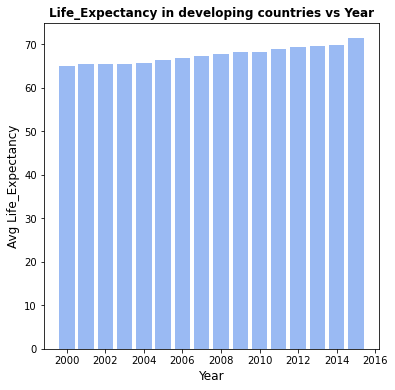

In [163]:
# Life_Expectancy through years
plt.figure(figsize=(6,6))
plt.bar(lifeExpecDevelping.groupby('Year')['Year'].count().index,lifeExpecDevelping.groupby('Year')['Life_Expectancy'].mean(),color='cornflowerblue',alpha=0.65)
plt.xlabel("Year",fontsize=12)
plt.ylabel("Avg Life_Expectancy",fontsize=12)
plt.title("Life_Expectancy in developing countries vs Year",fontweight='bold')
plt.show()

For both developed countries and developing countries, the lifespan are increased every year. And from analysis before, we also know that the increase of lifespan in developing countres increased more than those in developed countries. It worth to dig deeper to understand which area has improved for these two kind of countries.

In [164]:
## check correlation within features
lifeExpec['thinness_5to9_years'].corr(lifeExpec['thinness_10to19_years'])

0.9344957183969055

In [147]:
lifeExpec['Income_Comp_Of_Resources'].corr(lifeExpec['Schooling'])

0.7697843270545522

In [148]:
lifeExpec['Infant_Deaths'].corr(lifeExpec['Under_Five_Deaths'])

0.5492535243315712

In [149]:
lifeExpec['GDP'].corr(lifeExpec['Percentage_Exp'])

0.7118520842653635

From above analysis and also the heatmap, we could see that the correlation between thinness_10to19_years and thinness_5to9_years is  very high, close to 1. To avoid multicolinearity, we will only keep one of them.

## models
- linear regression
- random forest 

In [165]:
## fit linear regression model
response = lifeExpecDevelped["Life_Expectancy"]
predictors = lifeExpecDevelped[['Adult_Mortality','Percentage_Exp', 'GDP','Income_Comp_Of_Resources','Schooling','Population','thinness_10to19_years']]

In [166]:
model =sm.OLS(response,predictors).fit()
##print (model.params)
print (model.summary())

                                 OLS Regression Results                                
Dep. Variable:        Life_Expectancy   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          3.360e+04
Date:                Tue, 24 Nov 2020   Prob (F-statistic):                        0.00
Time:                        00:19:19   Log-Likelihood:                         -822.38
No. Observations:                 330   AIC:                                      1659.
Df Residuals:                     323   BIC:                                      1685.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [167]:
response = lifeExpecDevelped["Life_Expectancy"]
predictors1 = lifeExpecDevelped[['Adult_Mortality', 'GDP','Population','thinness_10to19_years']]

In [168]:
model1 =sm.OLS(response,predictors1).fit()
print (model1.summary())

                                 OLS Regression Results                                
Dep. Variable:        Life_Expectancy   R-squared (uncentered):                   0.931
Model:                            OLS   Adj. R-squared (uncentered):              0.930
Method:                 Least Squares   F-statistic:                              1101.
Date:                Tue, 24 Nov 2020   Prob (F-statistic):                   6.41e-188
Time:                        00:19:20   Log-Likelihood:                         -1468.7
No. Observations:                 330   AIC:                                      2945.
Df Residuals:                     326   BIC:                                      2961.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

In [169]:
from sklearn.model_selection import train_test_split
trainDataDeveloped = lifeExpecDevelped.drop(["Country", "Year",'Status'],axis=1)
##XDeveloped = trainDataDeveloped.drop(['Life_Expectancy'],axis=1)
XDeveloped = lifeExpecDevelped[['Adult_Mortality','Percentage_Exp', 'GDP','Income_Comp_Of_Resources','Schooling','Population','thinness_10to19_years']]
yDeveloped = trainDataDeveloped["Life_Expectancy"]
X_train, X_test, y_train, y_test = train_test_split(XDeveloped, yDeveloped, test_size=0.30, random_state=101)

In [170]:
from sklearn.linear_model import LinearRegression

In [171]:
Linear_model= LinearRegression()

In [172]:
Linear_model.fit(X_train,y_train)

LinearRegression()

In [173]:
predictions1=Linear_model.predict(X_test)

In [174]:
Linear_model.coef_

array([-6.44447964e-03,  5.20756207e-05, -2.00878260e-05,  5.40249732e+01,
       -4.65965926e-01,  7.79537727e-09, -1.43523735e+00])

In [175]:
lifeExpec.columns

Index(['Country', 'Year', 'Status', 'Life_Expectancy', 'Adult_Mortality',
       'Infant_Deaths', 'Alcohol', 'Percentage_Exp', 'HepatitisB', 'Measles',
       'BMI', 'Under_Five_Deaths', 'Polio', 'Tot_Exp', 'Diphtheria',
       'HIV/AIDS', 'GDP', 'Population', 'thinness_10to19_years',
       'thinness_5to9_years', 'Income_Comp_Of_Resources', 'Schooling'],
      dtype='object')

In [176]:
trainData = lifeExpec.drop(["Country", "Year",'Status'],axis=1)
X = trainData.drop(['Life_Expectancy'],axis=1)
y = trainData["Life_Expectancy"]

In [177]:
trainData2 = lifeExpec.drop(["Country", "Year",'Status','Schooling','thinness_10to19_years'],axis=1)
X = trainData2.drop(['Life_Expectancy'],axis=1)
y = trainData2["Life_Expectancy"]

In [178]:
trainData2.columns

Index(['Life_Expectancy', 'Adult_Mortality', 'Infant_Deaths', 'Alcohol',
       'Percentage_Exp', 'HepatitisB', 'Measles', 'BMI', 'Under_Five_Deaths',
       'Polio', 'Tot_Exp', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population',
       'thinness_5to9_years', 'Income_Comp_Of_Resources'],
      dtype='object')

In [179]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [180]:
## normalize data
scaler = StandardScaler() 
data_scaled = scaler.fit_transform(trainData2 )

In [181]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [182]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1.1509232365145219
Mean Squared Error: 3.183054927385892
Root Mean Squared Error: 1.7841118034994028


In [183]:
# Get numerical feature importances
importances = list(regressor.feature_importances_)
feature_list = list(X.columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: HIV/AIDS             Importance: 0.53
Variable: Income_Comp_Of_Resources Importance: 0.17
Variable: GDP                  Importance: 0.12
Variable: Adult_Mortality      Importance: 0.11
Variable: BMI                  Importance: 0.02
Variable: Alcohol              Importance: 0.01
Variable: Under_Five_Deaths    Importance: 0.01
Variable: Tot_Exp              Importance: 0.01
Variable: Population           Importance: 0.01
Variable: thinness_5to9_years  Importance: 0.01
Variable: Infant_Deaths        Importance: 0.0
Variable: Percentage_Exp       Importance: 0.0
Variable: HepatitisB           Importance: 0.0
Variable: Measles              Importance: 0.0
Variable: Polio                Importance: 0.0
Variable: Diphtheria           Importance: 0.0


In [184]:
trainDataDeveloped = lifeExpecDevelped.drop(["Country", "Year",'Status'],axis=1)
XDeveloped = trainDataDeveloped.drop(['Life_Expectancy'],axis=1)
yDeveloped = trainDataDeveloped["Life_Expectancy"]

In [185]:
## normalize data
scaler = StandardScaler() 
data_scaled = scaler.fit_transform(trainDataDeveloped )

In [186]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(XDeveloped, yDeveloped, test_size=0.2, random_state=0)

In [187]:
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [188]:
# Get numerical feature importances
importances = list(regressor.feature_importances_)
feature_list = list(X.columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: GDP                  Importance: 0.63
Variable: Adult_Mortality      Importance: 0.07
Variable: HepatitisB           Importance: 0.04
Variable: Alcohol              Importance: 0.03
Variable: BMI                  Importance: 0.03
Variable: Tot_Exp              Importance: 0.02
Variable: Population           Importance: 0.02
Variable: thinness_5to9_years  Importance: 0.02
Variable: Percentage_Exp       Importance: 0.01
Variable: Measles              Importance: 0.01
Variable: Under_Five_Deaths    Importance: 0.01
Variable: Diphtheria           Importance: 0.01
Variable: Income_Comp_Of_Resources Importance: 0.01
Variable: Infant_Deaths        Importance: 0.0
Variable: Polio                Importance: 0.0
Variable: HIV/AIDS             Importance: 0.0


Text(0.5, 1.0, 'Feature Importance in Developed Countries')

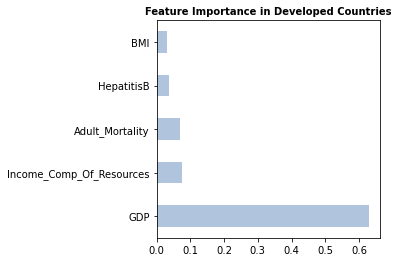

In [189]:
plt.figure(figsize = (4,4))
feat_importances = pd.Series(regressor.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5).plot(kind='barh', color = "lightsteelblue")
plt.title("Feature Importance in Developed Countries",fontsize = 10, fontWeight = 'bold')

In [190]:
trainDataDeveloping = lifeExpecDevelping.drop(["Country", "Year",'Status'],axis=1)
XDeveloping = trainDataDeveloping.drop(['Life_Expectancy'],axis=1)
yDeveloping = trainDataDeveloping["Life_Expectancy"]

In [191]:
## normalize data
scaler = StandardScaler() 
data_scaled = scaler.fit_transform(trainDataDeveloping )

X_train, X_test, y_train, y_test = train_test_split(XDeveloping, yDeveloping, test_size=0.2, random_state=0)
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

# Get numerical feature importances
importances = list(regressor.feature_importances_)
#feature_list = list(X.columns)
# List of tuples with variable and importance
#feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
#[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Text(0.5, 1.0, 'Feature Importance in Developing Countries')

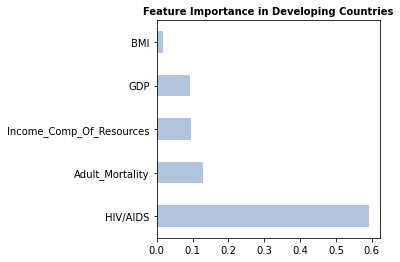

In [192]:
plt.figure(figsize = (4,4))
feat_importances = pd.Series(regressor.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5).plot(kind='barh',color = "lightsteelblue")
plt.title("Feature Importance in Developing Countries",fontsize = 10, fontWeight = 'bold')

In [193]:
## get the lifeexpectancy is lower than 50
lifeExpectLow = lifeExpec[lifeExpec["Life_Expectancy"] < 50]

In [194]:
len(lifeExpectLow["Country"].unique())

16

In [195]:
trainDataDevelopingLow = lifeExpectLow.drop(["Country", "Year",'Status'],axis=1)
XDevelopingLow = trainDataDevelopingLow.drop(['Life_Expectancy'],axis=1)
yDevelopingLow = trainDataDevelopingLow["Life_Expectancy"]

In [196]:
## normalize data
scaler = StandardScaler() 
data_scaled = scaler.fit_transform(trainDataDevelopingLow )

X_train, X_test, y_train, y_test = train_test_split(XDevelopingLow, yDevelopingLow, test_size=0.2, random_state=0)
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

# Get numerical feature importances
importances = list(regressor.feature_importances_)
feature_list = list(X.columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: GDP                  Importance: 0.19
Variable: Adult_Mortality      Importance: 0.16
Variable: BMI                  Importance: 0.13
Variable: Tot_Exp              Importance: 0.11
Variable: HIV/AIDS             Importance: 0.11
Variable: Under_Five_Deaths    Importance: 0.05
Variable: Population           Importance: 0.04
Variable: Alcohol              Importance: 0.02
Variable: Polio                Importance: 0.02
Variable: Diphtheria           Importance: 0.02
Variable: Income_Comp_Of_Resources Importance: 0.02
Variable: Infant_Deaths        Importance: 0.01
Variable: Percentage_Exp       Importance: 0.01
Variable: HepatitisB           Importance: 0.01
Variable: Measles              Importance: 0.01
Variable: thinness_5to9_years  Importance: 0.01


In [197]:
lifeExpectLow.describe()

Year  Life_Expectancy  Adult_Mortality  Infant_Deaths  \
count   103.000000       103.000000       103.000000     103.000000   
mean   2004.213592        46.727184       413.199612      73.844660   
std       3.426112         2.363538       223.961056     136.400776   
min    2000.000000        36.300000         4.000000       2.000000   
25%    2001.000000        45.450000       367.000000      17.000000   
50%    2004.000000        47.100000       463.000000      30.000000   
75%    2006.500000        48.500000       586.500000      49.500000   
max    2014.000000        49.900000       723.000000     576.000000   

          Alcohol  Percentage_Exp  HepatitisB        Measles         BMI  \
count  103.000000      103.000000  103.000000     103.000000  103.000000   
mean     3.462330       50.158760   56.019417   10428.543689   18.984466   
std      2.777351       72.987822   27.923909   32408.354300    6.830364   
min      0.010000        0.000000    6.000000       0.000000    2.200000   
25%      1.500000        8.901421   26.000000      34.000000   15.750000   
50%      2.690000       33.346915   64.000000     649.000000   17.800000   
75%      4.395000       53.210573   82.000000    2739.500000   22.450000   
max     10.570000      469.582390   99.000000  212183.000000   44.200000   

       Under_Five_Deaths       Polio     Tot_Exp  Diphtheria    HIV/AIDS  \
count         103.000000  103.000000  103.000000  103.000000  103.000000   
mean          119.213592   59.893204    6.045534   56.165049   13.830097   
std           220.934364   26.926885    2.719579   28.698602   12.305888   
min             4.000000    3.000000    1.120000    4.000000    0.600000   
25%            26.000000   42.000000    4.135000   33.500000    2.600000   
50%            48.000000   66.000000    5.700000   64.000000    9.000000   
75%            82.000000   84.000000    7.145000   83.000000   23.550000   
max           943.000000   99.000000   13.630000   99.000000   43.500000   

               GDP    Population  thinness_10to19_years  thinness_5to9_years  \
count   103.000000  1.030000e+02             103.000000           103.000000   
mean   1175.215022  1.794700e+07               7.271845             7.147573   
std    1238.344371  3.165332e+07               3.766166             3.788265   
min     272.991178  1.728340e+06               1.000000             1.000000   
25%     417.349084  4.426378e+06               4.050000             4.000000   
50%     805.292339  1.006701e+07               8.000000             7.800000   
75%    1230.780371  1.349387e+07               9.600000             9.550000   
max    5542.305427  1.426141e+08              14.300000            14.400000   

       Income_Comp_Of_Resources   Schooling  
count                103.000000  103.000000  
mean                   0.368893    8.192233  
std                    0.113717    2.104230  
min                    0.000000    3.900000  
25%                    0.318500    6.250000  
50%                    0.387000    8.500000  
75%                    0.437000    9.900000  
max                    0.580000   11.900000

In [198]:
lifeExpectLow.Country.unique()

array(['Angola', 'Botswana', 'Central African Republic', 'Chad',
       'Eritrea', 'Haiti', 'Lesotho', 'Malawi', 'Mali', 'Mozambique',
       'Nigeria', 'Rwanda', 'Sierra Leone', 'Uganda', 'Zambia',
       'Zimbabwe'], dtype=object)

Text(0.5, 1.0, 'Feature Importance in low Life Expetancy Countries')

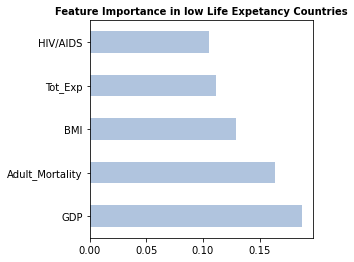

In [199]:
plt.figure(figsize = (4,4))
feat_importances = pd.Series(regressor.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5).plot(kind='barh',color = "lightsteelblue")
plt.title("Feature Importance in low Life Expetancy Countries", fontSize = 10,fontWeight = 'bold')

In [200]:
lowlife = round(lifeExpectLow["Life_Expectancy"].mean(),2)
devlife = round(lifeExpecDevelping["Life_Expectancy"].mean())
lowGDP = round(lifeExpectLow["GDP"].mean(),2)
devGDP = round(lifeExpecDevelping["GDP"].mean(),2)
lowMortality = round(lifeExpectLow["Adult_Mortality"].mean(),2)
devMortality = round(lifeExpecDevelping["Adult_Mortality"].mean(),2)

In [201]:
low = [lowlife,lowGDP,lowMortality]
dev = [devlife,devGDP,devMortality ]

Text(0.1, 68, '67')

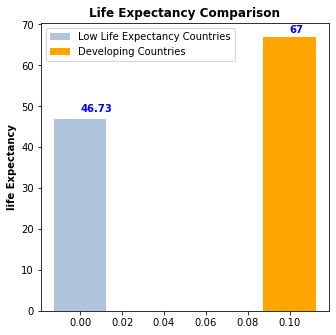

In [202]:
X = np.arange(1)
fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0,0,1,1])
ax.bar( 0.00, low[0], color = 'lightsteelblue', width = 0.025)
ax.bar( 0.1, dev[0], color = 'orange', width = 0.025)
ax.set_ylabel("life Expectancy",fontWeight = "bold")
ax.legend(loc ="upper left",labels=['Low Life Expectancy Countries', 'Developing Countries'])
ax.set_title("Life Expectancy Comparison",fontWeight = "bold")
plt.text( 0, low[0]+2,str(low[0]), color='blue', fontweight='bold' )
plt.text( 0.1, dev[0]+1,str(dev[0]), color='blue', fontweight='bold' )

Text(0.1, 6626.0, '6625.0')

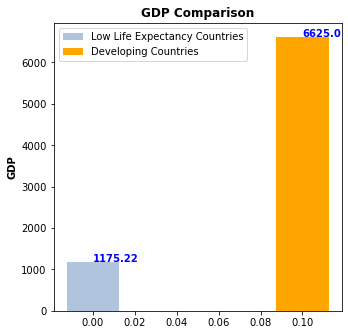

In [203]:
X = np.arange(1)
fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0,0,1,1])
ax.bar( 0.00, low[1], color = 'lightsteelblue', width = 0.025)
ax.bar( 0.1, dev[1], color = 'orange', width = 0.025)
ax.legend(loc = "upper left", labels=['Low Life Expectancy Countries', 'Developing Countries'])
ax.set_ylabel("GDP", fontWeight = "bold")
ax.set_title("GDP Comparison", fontWeight = "bold")
plt.text( 0, low[1]+2,str(low[1]), color='blue', fontweight='bold' )
plt.text( 0.1, dev[1]+1,str(dev[1]), color='blue', fontweight='bold' )

Text(0.1, 182.43, '181.43')

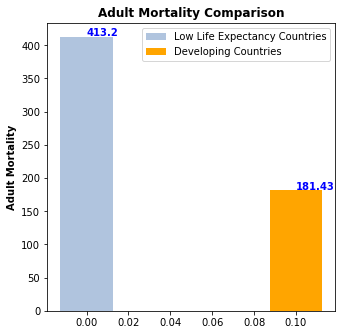

In [204]:
X = np.arange(1)
fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0,0,1,1])
ax.bar( 0.00, low[2], color = 'lightsteelblue', width = 0.025)
ax.bar( 0.1, dev[2], color = 'orange', width = 0.025)
ax.legend(labels=['Low Life Expectancy Countries', 'Developing Countries'])
ax.set_title("Adult Mortality Comparison",fontWeight = "bold")
ax.set_ylabel("Adult Mortality",fontWeight = "bold")
plt.text( 0, low[2]+2,str(low[2]), color='blue', fontweight='bold' )
plt.text( 0.1, dev[2]+1,str(dev[2]), color='blue', fontweight='bold' )

- From the analysis above, we observed that there is a significant difference in lifespan between developed countries and developing countries. And there is also an obvious phenomenon in our dataset.  Developing countries account for 86.3% of all the dataset, while developed countries only account for  13.7% of the total data. The two classes, developed countries and developing countries, are not equally represented in our dataset. Our learning algorithm may not generalize the behavior of minority classes, which are developed countries. In addition, based on the result of correlation and scatter plot shown in figure above, we could conclude that the factors that influence the life expectancy between developed countries and developed countries are different.
- For developed countries, the most important factors that influence life expectancy are GDP,Income_Comp_Of_Resources, and adult matility. For developing countries, HIV, adult mortality are very important. If want to improve the average life expectancy in these two categories of countries, we shoould work on specific area accordingly.
- Developing countries are a broad concept, so we want to dig deep to know if we could do something for the every short life expecancy countries. The results are surprise and make sense. These countries are too poor, they are far behind the average level of developing countries, see the comparison in above figures.
- In conclusion, we could gather more information from this dataset, such as why some countries increase more in life expectancy? why some are not? The more information we have, the more conclusion we could draw. Therefore, we ccould help these countries to improve their life expectancy.